In [6]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import backend

from deepctr.models import DeepFM
from deepctr.models import FNN
from deepctr.models import PNN
from deepctr.inputs import SparseFeat,get_feature_names
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import kerastuner

Using TensorFlow backend.


In [4]:
def build_anti_testset(X_train, fill=None):
        print("Building anti Train Dataset")
        anti_testset = []
        X_train=pd.DataFrame(X_train)
        adGroupList=pd.unique(X_train["adGroup"])
        placementList=pd.unique(X_train["placement"])
        anti_testset = []
        for adGroup in adGroupList:
            already=X_train.loc[X_train["adGroup"]==adGroup]["placement"]
            anti_testset += [{"adGroup": str(adGroup), "placement": str(placement)} for placement in placementList if placement not in already]
        
        anti_testset=pd.DataFrame(anti_testset)    
        anti_testset[["adGroup"]] = anti_testset[["adGroup"]].astype(int)
        
        anti_testset[["placement"]] = anti_testset[["placement"]].astype(int)

        return anti_testset

In [4]:
data = pd.read_csv("./result.csv")
sparse_features = ["adGroup", "placement","settings", "placementType"]
target = ['target']

# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

# 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(),embedding_dim=5)
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 3.generate input data for model
train, test = train_test_split(data, test_size=0.2)
# anti_testset=build_anti_testset(train,1)
# X_train=pd.DataFrame(X_train)
# print(len(anti_testset))
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}
# anti_testset_model_input= {name:anti_testset[name].values for name in feature_names}

In [7]:
def PrecisionRecall(x_test,pred,N):
    hit = 0
    n_recall = 1
    n_precision = 1
    adGroupList=pd.unique(x_test["adGroup"])
    pred[["adGroup"]] = pred[["adGroup"]].astype(int)
    print("N is {} ".format(N))
    print("Evaluating the model......")
    for adGroup in adGroupList:
        topN=pred.loc[pred["adGroup"]==adGroup].sort_values("target",ascending=False)[:N]
  
        groundTruth=x_test.loc[x_test["adGroup"]==adGroup]
        groundTruth=groundTruth[groundTruth["target"]>0]

        intersection = pd.merge(topN,
                 groundTruth,
                 how='inner', on=['adGroup','placement']
                 )
        hit += intersection.shape[0]
        n_recall += groundTruth.shape[0]
        n_precision += N
    print("Evaluation Finished!")
       
    return [hit / (1.0 * n_recall), hit / (1.0 * n_precision)]

In [69]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=1))

## Train DeepFM

In [27]:
# 4.Define Model,train,predict and evaluate
def buildModel(hp):
    activation = hp.Choice('activation', ['relu', 'selu'])
    dropout_rate = hp.Float(
                'dropout_rate', 0.0, 0.6, step=0.1, default=0.5)
    model = FNN(linear_feature_columns, dnn_feature_columns, task='regression',dnn_activation=activation,dnn_dropout=dropout_rate,dnn_hidden_units=(256, 128))
    model.compile( optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4,1e-5])), loss="mse", metrics=['mse'], )
    es = EarlyStopping(monitor='val_mse')
#     history = model.fit(train_model_input, train[target].values,
#                             batch_size=128, epochs=20, verbose=2, validation_split=0.2,callbacks=[es])
#     pred_ans = model.predict(test_model_input, batch_size=256)
    # To Evaluate Precision and Recall
    return model


In [10]:
tuner = RandomSearch(
    buildModel,
    objective='val_mse',
    max_trials=5,
    executions_per_trial=2,
    directory='test3')

tuner.search_space_summary()

tuner.search(x=train_model_input,
             y=train[target].values,callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)],
             epochs=10,
             validation_data=(test_model_input,test[target].values))

tuner.results_summary()



Train on 56643 samples, validate on 14161 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 27:05 - loss: 0.2409 - mse: 0.24 - ETA: 2:22 - loss: 0.3677 - mse: 0.3677 - ETA: 1:14 - loss: 0.3306 - mse: 0.330 - ETA: 53s - loss: 0.2963 - mse: 0.296 - ETA: 42s - loss: 0.2795 - mse: 0.27 - ETA: 34s - loss: 0.2697 - mse: 0.26 - ETA: 30s - loss: 0.2679 - mse: 0.26 - ETA: 27s - loss: 0.2728 - mse: 0.27 - ETA: 24s - loss: 0.2605 - mse: 0.26 - ETA: 22s - loss: 0.2508 - mse: 0.25 - ETA: 21s - loss: 0.2490 - mse: 0.24 - ETA: 19s - loss: 0.2460 - mse: 0.24 - ETA: 18s - loss: 0.2446 - mse: 0.24 - ETA: 17s - loss: 0.2392 - mse: 0.23 - ETA: 16s - loss: 0.2364 - mse: 0.23 - ETA: 15s - loss: 0.2303 - mse: 0.23 - ETA: 15s - loss: 0.2300 - mse: 0.23 - ETA: 14s - loss: 0.2272 - mse: 0.22 - ETA: 14s - loss: 0.2215 - mse: 0.22 - ETA: 13s - loss: 0.2206 - mse: 0.22 - ETA: 13s - loss: 0.2234 - mse: 0.22 - ETA: 12s - loss: 0.2208 - mse: 0.22 - ETA: 12s - loss: 0.2169 - mse: 0.21 - ETA: 12s - loss: 0.2158 - mse: 0.21 - ETA: 11s - loss: 0.2122 - mse: 0.

56643/56643 [==============================] - ETA: 9s - loss: 0.0702 - mse: 0.070 - ETA: 7s - loss: 0.0950 - mse: 0.095 - ETA: 7s - loss: 0.0966 - mse: 0.096 - ETA: 7s - loss: 0.1084 - mse: 0.108 - ETA: 7s - loss: 0.1105 - mse: 0.110 - ETA: 7s - loss: 0.1087 - mse: 0.108 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 7s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1153 - mse: 0.115 - ETA: 7s - loss: 0.1137 - mse: 0.113 - ETA: 7s - loss: 0.1135 - mse: 0.113 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1150 - mse: 0.115 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1178 - mse: 0.117 - ETA: 7s - loss: 0.1170 - mse: 0.117 - ETA: 7s - loss: 0.1156 - mse: 0.115 - ETA: 7s - loss: 0.1155 - mse: 0.115 - ETA: 7s - loss: 0.1162 - mse: 0.116 - ETA: 7s - loss: 0.1174 - mse: 0.117 - ETA: 6s - loss: 0.1182 - mse: 0.118 - ETA: 6s - loss: 0.1177 - mse: 0.117 - ETA: 6s - loss: 0.1152 - mse: 0.115 - ETA

56643/56643 [==============================] - ETA: 12s - loss: 0.1168 - mse: 0.11 - ETA: 7s - loss: 0.1560 - mse: 0.1560 - ETA: 7s - loss: 0.1203 - mse: 0.120 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1149 - mse: 0.114 - ETA: 7s - loss: 0.1076 - mse: 0.107 - ETA: 7s - loss: 0.1040 - mse: 0.104 - ETA: 7s - loss: 0.1020 - mse: 0.102 - ETA: 7s - loss: 0.1005 - mse: 0.100 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 7s - loss: 0.1041 - mse: 0.104 - ETA: 7s - loss: 0.1053 - mse: 0.105 - ETA: 7s - loss: 0.1054 - mse: 0.105 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1067 - mse: 0.106 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1064 - mse: 0.106 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 6s - loss: 0.1073 - mse: 0.107 - ETA: 6s - loss: 0.1083 - mse: 0.108 - ETA: 6s - loss: 0.1086 - mse: 0.108 - ET

56643/56643 [==============================] - ETA: 13s - loss: 0.0608 - mse: 0.06 - ETA: 8s - loss: 0.1255 - mse: 0.1255 - ETA: 8s - loss: 0.1195 - mse: 0.119 - ETA: 8s - loss: 0.1184 - mse: 0.118 - ETA: 8s - loss: 0.1224 - mse: 0.122 - ETA: 8s - loss: 0.1176 - mse: 0.117 - ETA: 8s - loss: 0.1145 - mse: 0.114 - ETA: 8s - loss: 0.1099 - mse: 0.109 - ETA: 8s - loss: 0.1115 - mse: 0.111 - ETA: 8s - loss: 0.1089 - mse: 0.108 - ETA: 8s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1112 - mse: 0.111 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1104 - mse: 0.110 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1105 - mse: 0.110 - ET

56643/56643 [==============================] - ETA: 8s - loss: 0.1009 - mse: 0.100 - ETA: 7s - loss: 0.1089 - mse: 0.108 - ETA: 7s - loss: 0.1031 - mse: 0.103 - ETA: 8s - loss: 0.1138 - mse: 0.113 - ETA: 8s - loss: 0.1110 - mse: 0.110 - ETA: 8s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1093 - mse: 0.109 - ETA: 7s - loss: 0.1141 - mse: 0.114 - ETA: 7s - loss: 0.1152 - mse: 0.115 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1132 - mse: 0.113 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1112 - mse: 0.111 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1131 - mse: 0.113 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.1484 - mse: 0.14 - ETA: 8s - loss: 0.0967 - mse: 0.0967 - ETA: 8s - loss: 0.1110 - mse: 0.111 - ETA: 8s - loss: 0.1106 - mse: 0.110 - ETA: 8s - loss: 0.1097 - mse: 0.109 - ETA: 8s - loss: 0.1093 - mse: 0.109 - ETA: 8s - loss: 0.1066 - mse: 0.106 - ETA: 8s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1063 - mse: 0.106 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1073 - mse: 0.107 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1074 - mse: 0.107 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1080 - mse: 0.107 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1087 - mse: 0.108 - ETA: 7s - loss: 0.1104 - mse: 0.110 - ETA: 7s - loss: 0.1105 - mse: 0.110 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ET

56643/56643 [==============================] - ETA: 13s - loss: 0.1393 - mse: 0.13 - ETA: 8s - loss: 0.0920 - mse: 0.0920 - ETA: 8s - loss: 0.0883 - mse: 0.088 - ETA: 8s - loss: 0.0899 - mse: 0.089 - ETA: 8s - loss: 0.0973 - mse: 0.097 - ETA: 8s - loss: 0.0957 - mse: 0.095 - ETA: 8s - loss: 0.0971 - mse: 0.097 - ETA: 8s - loss: 0.0977 - mse: 0.097 - ETA: 8s - loss: 0.0982 - mse: 0.098 - ETA: 8s - loss: 0.0986 - mse: 0.098 - ETA: 8s - loss: 0.1015 - mse: 0.101 - ETA: 7s - loss: 0.1020 - mse: 0.101 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1026 - mse: 0.102 - ETA: 7s - loss: 0.1042 - mse: 0.104 - ETA: 7s - loss: 0.1025 - mse: 0.102 - ETA: 7s - loss: 0.1027 - mse: 0.102 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1027 - mse: 0.102 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1039 - mse: 0.103 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1044 - mse: 0.104 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0598 - mse: 0.05 - ETA: 7s - loss: 0.0910 - mse: 0.0910 - ETA: 7s - loss: 0.0951 - mse: 0.095 - ETA: 7s - loss: 0.0944 - mse: 0.094 - ETA: 7s - loss: 0.0938 - mse: 0.093 - ETA: 7s - loss: 0.0981 - mse: 0.098 - ETA: 7s - loss: 0.0959 - mse: 0.095 - ETA: 7s - loss: 0.0995 - mse: 0.099 - ETA: 7s - loss: 0.1008 - mse: 0.100 - ETA: 7s - loss: 0.1017 - mse: 0.101 - ETA: 7s - loss: 0.1090 - mse: 0.109 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 6s - loss: 0.1083 - mse: 0.108 - ETA: 6s - loss: 0.1065 - mse: 0.106 - ETA: 6s - loss: 0.1057 - mse: 0.105 - ETA: 6s - loss: 0.1037 - mse: 0.103 - ETA: 6s - loss: 0.1042 - mse: 0.104 - ETA: 6s - loss: 0.1056 - mse: 0.105 - ETA: 6s - loss: 0.1054 - mse: 0.105 - ETA: 6s - loss: 0.1058 - mse: 0.105 - ETA: 6s - loss: 0.1055 - mse: 0.105 - ETA: 6s - loss: 0.1070 - mse: 0.106 - ETA: 6s - loss: 0.1055 - mse: 0.105 - ETA: 6s - loss: 0.1072 - mse: 0.107 - ETA: 6s - loss: 0.1058 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0741 - mse: 0.074 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.0947 - mse: 0.094 - ETA: 7s - loss: 0.1032 - mse: 0.103 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1089 - mse: 0.108 - ETA: 7s - loss: 0.1078 - mse: 0.107 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1056 - mse: 0.105 - ETA: 7s - loss: 0.1036 - mse: 0.103 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1045 - mse: 0.104 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1113 - mse: 0.111 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 6s - loss: 0.1064 - mse: 0.106 - ETA: 6s - loss: 0.1080 - mse: 0.108 - ETA: 6s - loss: 0.1078 - mse: 0.107 - ETA: 6s - loss: 0.1060 - mse: 0.106 - ETA: 6s - loss: 0.1057 - mse: 0.105 - ETA: 6s - loss: 0.1059 - mse: 0.105 - ETA: 6s - loss: 0.1045 - mse: 0.104 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.0885 - mse: 0.08 - ETA: 7s - loss: 0.1072 - mse: 0.1072 - ETA: 8s - loss: 0.1076 - mse: 0.107 - ETA: 8s - loss: 0.1125 - mse: 0.112 - ETA: 8s - loss: 0.1114 - mse: 0.111 - ETA: 8s - loss: 0.1094 - mse: 0.109 - ETA: 8s - loss: 0.1083 - mse: 0.108 - ETA: 7s - loss: 0.1058 - mse: 0.105 - ETA: 7s - loss: 0.1032 - mse: 0.103 - ETA: 7s - loss: 0.1014 - mse: 0.101 - ETA: 7s - loss: 0.1020 - mse: 0.102 - ETA: 7s - loss: 0.1033 - mse: 0.103 - ETA: 7s - loss: 0.1024 - mse: 0.102 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 7s - loss: 0.0998 - mse: 0.099 - ETA: 7s - loss: 0.0986 - mse: 0.098 - ETA: 7s - loss: 0.0988 - mse: 0.098 - ETA: 7s - loss: 0.0987 - mse: 0.098 - ETA: 6s - loss: 0.0991 - mse: 0.099 - ETA: 6s - loss: 0.1001 - mse: 0.100 - ETA: 6s - loss: 0.1016 - mse: 0.101 - ETA: 6s - loss: 0.1015 - mse: 0.101 - ETA: 6s - loss: 0.1016 - mse: 0.101 - ETA: 6s - loss: 0.1034 - mse: 0.103 - ET

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 26:49 - loss: 0.3097 - mse: 0.30 - ETA: 2:09 - loss: 0.3290 - mse: 0.3290 - ETA: 1:10 - loss: 0.3098 - mse: 0.309 - ETA: 49s - loss: 0.3019 - mse: 0.301 - ETA: 39s - loss: 0.2975 - mse: 0.29 - ETA: 33s - loss: 0.2828 - mse: 0.28 - ETA: 29s - loss: 0.2722 - mse: 0.27 - ETA: 26s - loss: 0.2652 - mse: 0.26 - ETA: 24s - loss: 0.2583 - mse: 0.25 - ETA: 22s - loss: 0.2620 - mse: 0.26 - ETA: 20s - loss: 0.2577 - mse: 0.25 - ETA: 19s - loss: 0.2493 - mse: 0.24 - ETA: 18s - loss: 0.2443 - mse: 0.24 - ETA: 17s - loss: 0.2410 - mse: 0.24 - ETA: 16s - loss: 0.2429 - mse: 0.24 - ETA: 15s - loss: 0.2388 - mse: 0.23 - ETA: 15s - loss: 0.2352 - mse: 0.23 - ETA: 14s - loss: 0.2340 - mse: 0.23 - ETA: 14s - loss: 0.2294 - mse: 0.22 - ETA: 13s - loss: 0.2239 - mse: 0.22 - ETA: 13s - loss: 0.2200 - mse: 0.22 - ETA: 12s - loss: 0.2195 - mse: 0.21 - ETA: 12s - loss: 0.2162 - mse: 0.21 - ETA: 12s - loss: 0.2150 - mse: 0.21 - ETA: 12s - loss: 0.2123 - mse: 0.

56643/56643 [==============================] - ETA: 13s - loss: 0.0885 - mse: 0.08 - ETA: 8s - loss: 0.0960 - mse: 0.0959 - ETA: 8s - loss: 0.1141 - mse: 0.114 - ETA: 8s - loss: 0.1158 - mse: 0.115 - ETA: 8s - loss: 0.1128 - mse: 0.112 - ETA: 8s - loss: 0.1080 - mse: 0.108 - ETA: 8s - loss: 0.1041 - mse: 0.104 - ETA: 8s - loss: 0.1044 - mse: 0.104 - ETA: 8s - loss: 0.1093 - mse: 0.109 - ETA: 8s - loss: 0.1086 - mse: 0.108 - ETA: 8s - loss: 0.1075 - mse: 0.107 - ETA: 8s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1085 - mse: 0.108 - ETA: 7s - loss: 0.1127 - mse: 0.112 - ETA: 7s - loss: 0.1129 - mse: 0.112 - ETA: 7s - loss: 0.1135 - mse: 0.113 - ETA: 7s - loss: 0.1156 - mse: 0.115 - ETA: 7s - loss: 0.1142 - mse: 0.114 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1129 - mse: 0.112 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 7s - loss: 0.1138 - mse: 0.113 - ETA: 7s - loss: 0.1135 - mse: 0.113 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1146 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 13s - loss: 0.0810 - mse: 0.08 - ETA: 8s - loss: 0.1132 - mse: 0.1132 - ETA: 8s - loss: 0.1165 - mse: 0.116 - ETA: 8s - loss: 0.1148 - mse: 0.114 - ETA: 8s - loss: 0.1182 - mse: 0.118 - ETA: 8s - loss: 0.1133 - mse: 0.113 - ETA: 8s - loss: 0.1154 - mse: 0.115 - ETA: 8s - loss: 0.1142 - mse: 0.114 - ETA: 8s - loss: 0.1148 - mse: 0.114 - ETA: 7s - loss: 0.1229 - mse: 0.122 - ETA: 7s - loss: 0.1237 - mse: 0.123 - ETA: 7s - loss: 0.1228 - mse: 0.122 - ETA: 7s - loss: 0.1206 - mse: 0.120 - ETA: 7s - loss: 0.1194 - mse: 0.119 - ETA: 7s - loss: 0.1181 - mse: 0.118 - ETA: 7s - loss: 0.1166 - mse: 0.116 - ETA: 7s - loss: 0.1136 - mse: 0.113 - ETA: 7s - loss: 0.1119 - mse: 0.111 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 7s - loss: 0.1136 - mse: 0.113 - ETA: 7s - loss: 0.1136 - mse: 0.113 - ETA: 7s - loss: 0.1155 - mse: 0.115 - ETA: 6s - loss: 0.1157 - mse: 0.115 - ETA: 6s - loss: 0.1149 - mse: 0.114 - ETA: 6s - loss: 0.1145 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 11s - loss: 0.3377 - mse: 0.33 - ETA: 8s - loss: 0.1152 - mse: 0.1152 - ETA: 8s - loss: 0.1226 - mse: 0.122 - ETA: 7s - loss: 0.1314 - mse: 0.131 - ETA: 7s - loss: 0.1288 - mse: 0.128 - ETA: 7s - loss: 0.1284 - mse: 0.128 - ETA: 7s - loss: 0.1304 - mse: 0.130 - ETA: 7s - loss: 0.1282 - mse: 0.128 - ETA: 7s - loss: 0.1244 - mse: 0.124 - ETA: 7s - loss: 0.1239 - mse: 0.123 - ETA: 7s - loss: 0.1200 - mse: 0.120 - ETA: 7s - loss: 0.1201 - mse: 0.120 - ETA: 7s - loss: 0.1183 - mse: 0.118 - ETA: 7s - loss: 0.1185 - mse: 0.118 - ETA: 7s - loss: 0.1171 - mse: 0.117 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1161 - mse: 0.116 - ETA: 7s - loss: 0.1184 - mse: 0.118 - ETA: 7s - loss: 0.1177 - mse: 0.117 - ETA: 7s - loss: 0.1187 - mse: 0.118 - ETA: 7s - loss: 0.1194 - mse: 0.119 - ETA: 7s - loss: 0.1184 - mse: 0.118 - ETA: 7s - loss: 0.1183 - mse: 0.118 - ETA: 6s - loss: 0.1188 - mse: 0.118 - ETA: 6s - loss: 0.1196 - mse: 0.119 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.2156 - mse: 0.21 - ETA: 8s - loss: 0.1432 - mse: 0.1432 - ETA: 8s - loss: 0.1214 - mse: 0.121 - ETA: 7s - loss: 0.1201 - mse: 0.120 - ETA: 7s - loss: 0.1104 - mse: 0.110 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1090 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1110 - mse: 0.111 - ETA: 7s - loss: 0.1118 - mse: 0.111 - ETA: 6s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1113 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1129 - mse: 0.112 - ETA: 6s - loss: 0.1122 - mse: 0.112 - ETA: 6s - loss: 0.1118 - mse: 0.111 - ETA: 6s - loss: 0.1124 - mse: 0.112 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.1458 - mse: 0.145 - ETA: 7s - loss: 0.1155 - mse: 0.115 - ETA: 8s - loss: 0.1325 - mse: 0.132 - ETA: 8s - loss: 0.1166 - mse: 0.116 - ETA: 8s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1131 - mse: 0.113 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1137 - mse: 0.113 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1113 - mse: 0.111 - ETA: 7s - loss: 0.1102 - mse: 0.110 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1112 - mse: 0.111 - ETA: 6s - loss: 0.1117 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1112 - mse: 0.111 - ETA: 6s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1114 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.0869 - mse: 0.086 - ETA: 8s - loss: 0.0841 - mse: 0.084 - ETA: 7s - loss: 0.1151 - mse: 0.115 - ETA: 7s - loss: 0.1239 - mse: 0.123 - ETA: 7s - loss: 0.1150 - mse: 0.114 - ETA: 7s - loss: 0.1166 - mse: 0.116 - ETA: 7s - loss: 0.1148 - mse: 0.114 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1083 - mse: 0.108 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1073 - mse: 0.107 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1063 - mse: 0.106 - ETA: 7s - loss: 0.1070 - mse: 0.107 - ETA: 7s - loss: 0.1085 - mse: 0.108 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1080 - mse: 0.108 - ETA: 7s - loss: 0.1096 - mse: 0.109 - ETA: 6s - loss: 0.1095 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1087 - mse: 0.108 - ETA: 6s - loss: 0.1089 - mse: 0.108 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.1191 - mse: 0.119 - ETA: 8s - loss: 0.1127 - mse: 0.112 - ETA: 8s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1162 - mse: 0.116 - ETA: 7s - loss: 0.1234 - mse: 0.123 - ETA: 7s - loss: 0.1178 - mse: 0.117 - ETA: 7s - loss: 0.1170 - mse: 0.117 - ETA: 7s - loss: 0.1136 - mse: 0.113 - ETA: 7s - loss: 0.1151 - mse: 0.115 - ETA: 7s - loss: 0.1139 - mse: 0.113 - ETA: 7s - loss: 0.1130 - mse: 0.112 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 7s - loss: 0.1089 - mse: 0.108 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1092 - mse: 0.109 - ETA: 6s - loss: 0.1082 - mse: 0.108 - ETA: 6s - loss: 0.1099 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1094 - mse: 0.109 - ETA: 6s - loss: 0.1093 - mse: 0.109 - ETA: 6s - loss: 0.1083 - mse: 0.108 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.0645 - mse: 0.06 - ETA: 8s - loss: 0.0998 - mse: 0.0998 - ETA: 8s - loss: 0.1007 - mse: 0.100 - ETA: 8s - loss: 0.0961 - mse: 0.096 - ETA: 8s - loss: 0.0987 - mse: 0.098 - ETA: 8s - loss: 0.1013 - mse: 0.101 - ETA: 8s - loss: 0.1000 - mse: 0.100 - ETA: 8s - loss: 0.1033 - mse: 0.103 - ETA: 8s - loss: 0.1043 - mse: 0.104 - ETA: 8s - loss: 0.1061 - mse: 0.106 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1053 - mse: 0.105 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 7s - loss: 0.1060 - mse: 0.105 - ETA: 7s - loss: 0.1059 - mse: 0.105 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1087 - mse: 0.108 - ETA: 7s - loss: 0.1071 - mse: 0.107 - ETA: 6s - loss: 0.1067 - mse: 0.106 - ETA: 6s - loss: 0.1066 - mse: 0.106 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0824 - mse: 0.082 - ETA: 7s - loss: 0.0954 - mse: 0.095 - ETA: 7s - loss: 0.0953 - mse: 0.095 - ETA: 7s - loss: 0.0909 - mse: 0.090 - ETA: 7s - loss: 0.0941 - mse: 0.094 - ETA: 7s - loss: 0.0934 - mse: 0.093 - ETA: 7s - loss: 0.0966 - mse: 0.096 - ETA: 7s - loss: 0.0993 - mse: 0.099 - ETA: 7s - loss: 0.0973 - mse: 0.097 - ETA: 7s - loss: 0.0965 - mse: 0.096 - ETA: 7s - loss: 0.0976 - mse: 0.097 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 6s - loss: 0.1019 - mse: 0.101 - ETA: 6s - loss: 0.1014 - mse: 0.101 - ETA: 6s - loss: 0.1028 - mse: 0.102 - ETA: 6s - loss: 0.1022 - mse: 0.102 - ETA: 6s - loss: 0.1027 - mse: 0.102 - ETA: 6s - loss: 0.1017 - mse: 0.101 - ETA: 6s - loss: 0.1018 - mse: 0.101 - ETA: 6s - loss: 0.1016 - mse: 0.101 - ETA: 6s - loss: 0.1013 - mse: 0.101 - ETA: 6s - loss: 0.1002 - mse: 0.100 - ETA: 6s - loss: 0.1008 - mse: 0.100 - ETA: 6s - loss: 0.1010 - mse: 0.101 - ETA: 6s - loss: 0.1005 - mse: 0.100 - ETA

Train on 56643 samples, validate on 14161 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 28:10 - loss: 0.1256 - mse: 0.12 - ETA: 2:16 - loss: 0.3185 - mse: 0.3185 - ETA: 1:13 - loss: 0.2878 - mse: 0.287 - ETA: 51s - loss: 0.2785 - mse: 0.278 - ETA: 40s - loss: 0.2570 - mse: 0.25 - ETA: 33s - loss: 0.2402 - mse: 0.24 - ETA: 29s - loss: 0.2300 - mse: 0.23 - ETA: 26s - loss: 0.2216 - mse: 0.22 - ETA: 23s - loss: 0.2097 - mse: 0.20 - ETA: 22s - loss: 0.2036 - mse: 0.20 - ETA: 20s - loss: 0.2019 - mse: 0.20 - ETA: 19s - loss: 0.1933 - mse: 0.19 - ETA: 18s - loss: 0.1890 - mse: 0.18 - ETA: 17s - loss: 0.1853 - mse: 0.18 - ETA: 16s - loss: 0.1845 - mse: 0.18 - ETA: 15s - loss: 0.1824 - mse: 0.18 - ETA: 14s - loss: 0.1813 - mse: 0.18 - ETA: 14s - loss: 0.1803 - mse: 0.18 - ETA: 13s - loss: 0.1771 - mse: 0.17 - ETA: 13s - loss: 0.1743 - mse: 0.17 - ETA: 12s - loss: 0.1731 - mse: 0.17 - ETA: 12s - loss: 0.1707 - mse: 0.17 - ETA: 12s - loss: 0.1688 - mse: 0.16 - ETA: 11s - loss: 0.1663 - mse: 0.16 - ETA: 11s - loss: 0.1643 - mse: 0.

56643/56643 [==============================] - ETA: 9s - loss: 0.2645 - mse: 0.264 - ETA: 7s - loss: 0.1374 - mse: 0.137 - ETA: 7s - loss: 0.1225 - mse: 0.122 - ETA: 7s - loss: 0.1112 - mse: 0.111 - ETA: 7s - loss: 0.1120 - mse: 0.111 - ETA: 7s - loss: 0.1139 - mse: 0.113 - ETA: 7s - loss: 0.1197 - mse: 0.119 - ETA: 7s - loss: 0.1185 - mse: 0.118 - ETA: 7s - loss: 0.1188 - mse: 0.118 - ETA: 7s - loss: 0.1193 - mse: 0.119 - ETA: 7s - loss: 0.1199 - mse: 0.119 - ETA: 7s - loss: 0.1174 - mse: 0.117 - ETA: 7s - loss: 0.1183 - mse: 0.118 - ETA: 7s - loss: 0.1170 - mse: 0.116 - ETA: 6s - loss: 0.1168 - mse: 0.116 - ETA: 6s - loss: 0.1160 - mse: 0.115 - ETA: 6s - loss: 0.1166 - mse: 0.116 - ETA: 6s - loss: 0.1175 - mse: 0.117 - ETA: 6s - loss: 0.1164 - mse: 0.116 - ETA: 6s - loss: 0.1155 - mse: 0.115 - ETA: 6s - loss: 0.1151 - mse: 0.114 - ETA: 6s - loss: 0.1155 - mse: 0.115 - ETA: 6s - loss: 0.1152 - mse: 0.115 - ETA: 6s - loss: 0.1156 - mse: 0.115 - ETA: 6s - loss: 0.1155 - mse: 0.115 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.0821 - mse: 0.081 - ETA: 7s - loss: 0.0946 - mse: 0.094 - ETA: 8s - loss: 0.1018 - mse: 0.101 - ETA: 8s - loss: 0.0965 - mse: 0.096 - ETA: 8s - loss: 0.1074 - mse: 0.107 - ETA: 8s - loss: 0.1024 - mse: 0.102 - ETA: 7s - loss: 0.1058 - mse: 0.105 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1054 - mse: 0.105 - ETA: 7s - loss: 0.1064 - mse: 0.106 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1072 - mse: 0.106 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1103 - mse: 0.109 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1121 - mse: 0.111 - ETA: 7s - loss: 0.1113 - mse: 0.111 - ETA: 7s - loss: 0.1101 - mse: 0.109 - ETA: 6s - loss: 0.1101 - mse: 0.109 - ETA: 6s - loss: 0.1084 - mse: 0.108 - ETA: 6s - loss: 0.1077 - mse: 0.107 - ETA: 6s - loss: 0.1083 - mse: 0.107 - ETA: 6s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1121 - mse: 0.111 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.0884 - mse: 0.08 - ETA: 8s - loss: 0.0867 - mse: 0.0861 - ETA: 8s - loss: 0.1021 - mse: 0.101 - ETA: 8s - loss: 0.0984 - mse: 0.097 - ETA: 8s - loss: 0.1014 - mse: 0.100 - ETA: 8s - loss: 0.1021 - mse: 0.101 - ETA: 8s - loss: 0.1062 - mse: 0.105 - ETA: 7s - loss: 0.1091 - mse: 0.108 - ETA: 7s - loss: 0.1110 - mse: 0.110 - ETA: 7s - loss: 0.1138 - mse: 0.113 - ETA: 7s - loss: 0.1141 - mse: 0.113 - ETA: 7s - loss: 0.1123 - mse: 0.111 - ETA: 7s - loss: 0.1129 - mse: 0.112 - ETA: 7s - loss: 0.1122 - mse: 0.111 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1102 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.109 - ETA: 7s - loss: 0.1105 - mse: 0.109 - ETA: 6s - loss: 0.1117 - mse: 0.111 - ETA: 6s - loss: 0.1113 - mse: 0.110 - ETA: 6s - loss: 0.1112 - mse: 0.110 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0373 - mse: 0.036 - ETA: 7s - loss: 0.1245 - mse: 0.123 - ETA: 8s - loss: 0.1159 - mse: 0.115 - ETA: 7s - loss: 0.1101 - mse: 0.109 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1027 - mse: 0.102 - ETA: 7s - loss: 0.1024 - mse: 0.101 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1056 - mse: 0.104 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1066 - mse: 0.105 - ETA: 7s - loss: 0.1068 - mse: 0.106 - ETA: 7s - loss: 0.1095 - mse: 0.108 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 6s - loss: 0.1085 - mse: 0.107 - ETA: 6s - loss: 0.1082 - mse: 0.107 - ETA: 6s - loss: 0.1076 - mse: 0.106 - ETA: 6s - loss: 0.1083 - mse: 0.107 - ETA: 6s - loss: 0.1082 - mse: 0.107 - ETA: 6s - loss: 0.1090 - mse: 0.108 - ETA: 6s - loss: 0.1096 - mse: 0.108 - ETA: 6s - loss: 0.1092 - mse: 0.108 - ETA: 6s - loss: 0.1095 - mse: 0.108 - ETA

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 26:29 - loss: 0.1246 - mse: 0.12 - ETA: 2:19 - loss: 0.2718 - mse: 0.2718 - ETA: 1:09 - loss: 0.2469 - mse: 0.246 - ETA: 49s - loss: 0.2426 - mse: 0.242 - ETA: 38s - loss: 0.2324 - mse: 0.23 - ETA: 33s - loss: 0.2341 - mse: 0.23 - ETA: 29s - loss: 0.2267 - mse: 0.22 - ETA: 25s - loss: 0.2259 - mse: 0.22 - ETA: 23s - loss: 0.2243 - mse: 0.22 - ETA: 21s - loss: 0.2182 - mse: 0.21 - ETA: 20s - loss: 0.2161 - mse: 0.21 - ETA: 18s - loss: 0.2110 - mse: 0.21 - ETA: 17s - loss: 0.2048 - mse: 0.20 - ETA: 16s - loss: 0.2045 - mse: 0.20 - ETA: 15s - loss: 0.2014 - mse: 0.20 - ETA: 15s - loss: 0.1971 - mse: 0.19 - ETA: 14s - loss: 0.1927 - mse: 0.19 - ETA: 14s - loss: 0.1894 - mse: 0.18 - ETA: 13s - loss: 0.1891 - mse: 0.18 - ETA: 13s - loss: 0.1887 - mse: 0.18 - ETA: 12s - loss: 0.1851 - mse: 0.18 - ETA: 12s - loss: 0.1838 - mse: 0.18 - ETA: 12s - loss: 0.1799 - mse: 0.17 - ETA: 11s - loss: 0.1778 - mse: 0.17 - ETA: 11s - loss: 0.1754 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.0923 - mse: 0.09 - ETA: 7s - loss: 0.1729 - mse: 0.1727 - ETA: 7s - loss: 0.1452 - mse: 0.145 - ETA: 7s - loss: 0.1454 - mse: 0.145 - ETA: 7s - loss: 0.1401 - mse: 0.139 - ETA: 7s - loss: 0.1365 - mse: 0.136 - ETA: 7s - loss: 0.1305 - mse: 0.130 - ETA: 7s - loss: 0.1283 - mse: 0.128 - ETA: 7s - loss: 0.1263 - mse: 0.126 - ETA: 7s - loss: 0.1221 - mse: 0.121 - ETA: 7s - loss: 0.1205 - mse: 0.120 - ETA: 7s - loss: 0.1204 - mse: 0.120 - ETA: 7s - loss: 0.1211 - mse: 0.120 - ETA: 7s - loss: 0.1216 - mse: 0.121 - ETA: 7s - loss: 0.1220 - mse: 0.121 - ETA: 7s - loss: 0.1205 - mse: 0.120 - ETA: 7s - loss: 0.1195 - mse: 0.119 - ETA: 7s - loss: 0.1189 - mse: 0.118 - ETA: 7s - loss: 0.1182 - mse: 0.118 - ETA: 7s - loss: 0.1183 - mse: 0.118 - ETA: 7s - loss: 0.1182 - mse: 0.118 - ETA: 6s - loss: 0.1192 - mse: 0.119 - ETA: 6s - loss: 0.1194 - mse: 0.119 - ETA: 6s - loss: 0.1198 - mse: 0.119 - ETA: 6s - loss: 0.1199 - mse: 0.119 - ET

56643/56643 [==============================] - ETA: 11s - loss: 0.0687 - mse: 0.06 - ETA: 7s - loss: 0.1258 - mse: 0.1254 - ETA: 7s - loss: 0.1298 - mse: 0.129 - ETA: 7s - loss: 0.1202 - mse: 0.119 - ETA: 7s - loss: 0.1162 - mse: 0.115 - ETA: 7s - loss: 0.1070 - mse: 0.106 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 7s - loss: 0.1060 - mse: 0.105 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.1062 - mse: 0.105 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1051 - mse: 0.104 - ETA: 7s - loss: 0.1060 - mse: 0.105 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 6s - loss: 0.1100 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.108 - ETA: 6s - loss: 0.1104 - mse: 0.110 - ETA: 6s - loss: 0.1101 - mse: 0.109 - ETA: 6s - loss: 0.1100 - mse: 0.109 - ETA: 6s - loss: 0.1092 - mse: 0.108 - ETA: 6s - loss: 0.1094 - mse: 0.109 - ETA: 6s - loss: 0.1096 - mse: 0.109 - ETA: 6s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1110 - mse: 0.110 - ETA: 6s - loss: 0.1112 - mse: 0.110 - ET

56643/56643 [==============================] - ETA: 8s - loss: 0.1022 - mse: 0.101 - ETA: 7s - loss: 0.1061 - mse: 0.105 - ETA: 7s - loss: 0.0935 - mse: 0.093 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.1002 - mse: 0.099 - ETA: 7s - loss: 0.1050 - mse: 0.104 - ETA: 7s - loss: 0.1054 - mse: 0.104 - ETA: 7s - loss: 0.1037 - mse: 0.103 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.1054 - mse: 0.104 - ETA: 7s - loss: 0.1036 - mse: 0.103 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1061 - mse: 0.105 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 6s - loss: 0.1055 - mse: 0.105 - ETA: 6s - loss: 0.1069 - mse: 0.106 - ETA: 6s - loss: 0.1070 - mse: 0.106 - ETA: 6s - loss: 0.1082 - mse: 0.107 - ETA: 6s - loss: 0.1084 - mse: 0.107 - ETA: 6s - loss: 0.1106 - mse: 0.110 - ETA: 6s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1103 - mse: 0.109 - ETA: 6s - loss: 0.1105 - mse: 0.110 - ETA: 6s - loss: 0.1106 - mse: 0.110 - ETA: 6s - loss: 0.1106 - mse: 0.110 - ETA

56643/56643 [==============================] - ETA: 13s - loss: 0.0809 - mse: 0.08 - ETA: 8s - loss: 0.1042 - mse: 0.1035 - ETA: 7s - loss: 0.1178 - mse: 0.117 - ETA: 7s - loss: 0.1158 - mse: 0.115 - ETA: 7s - loss: 0.1091 - mse: 0.108 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1055 - mse: 0.104 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1076 - mse: 0.106 - ETA: 7s - loss: 0.1075 - mse: 0.106 - ETA: 7s - loss: 0.1042 - mse: 0.103 - ETA: 7s - loss: 0.1061 - mse: 0.105 - ETA: 7s - loss: 0.1053 - mse: 0.104 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1045 - mse: 0.103 - ETA: 7s - loss: 0.1058 - mse: 0.105 - ETA: 7s - loss: 0.1051 - mse: 0.104 - ETA: 6s - loss: 0.1035 - mse: 0.102 - ETA: 6s - loss: 0.1031 - mse: 0.102 - ETA: 6s - loss: 0.1041 - mse: 0.103 - ETA: 6s - loss: 0.1048 - mse: 0.104 - ETA: 6s - loss: 0.1064 - mse: 0.105 - ETA: 6s - loss: 0.1061 - mse: 0.105 - ETA: 6s - loss: 0.1064 - mse: 0.105 - ETA: 6s - loss: 0.1075 - mse: 0.106 - ET

56643/56643 [==============================] - ETA: 13s - loss: 0.1473 - mse: 0.14 - ETA: 9s - loss: 0.1277 - mse: 0.1269 - ETA: 8s - loss: 0.1073 - mse: 0.106 - ETA: 8s - loss: 0.1028 - mse: 0.101 - ETA: 8s - loss: 0.0983 - mse: 0.097 - ETA: 8s - loss: 0.0958 - mse: 0.095 - ETA: 7s - loss: 0.0997 - mse: 0.098 - ETA: 7s - loss: 0.1000 - mse: 0.099 - ETA: 7s - loss: 0.0988 - mse: 0.098 - ETA: 7s - loss: 0.1001 - mse: 0.099 - ETA: 7s - loss: 0.0999 - mse: 0.099 - ETA: 7s - loss: 0.1008 - mse: 0.100 - ETA: 7s - loss: 0.1040 - mse: 0.103 - ETA: 7s - loss: 0.1037 - mse: 0.102 - ETA: 7s - loss: 0.1030 - mse: 0.102 - ETA: 7s - loss: 0.1024 - mse: 0.101 - ETA: 7s - loss: 0.1031 - mse: 0.102 - ETA: 7s - loss: 0.1035 - mse: 0.102 - ETA: 7s - loss: 0.1039 - mse: 0.103 - ETA: 6s - loss: 0.1046 - mse: 0.103 - ETA: 6s - loss: 0.1044 - mse: 0.103 - ETA: 6s - loss: 0.1049 - mse: 0.104 - ETA: 6s - loss: 0.1051 - mse: 0.104 - ETA: 6s - loss: 0.1057 - mse: 0.104 - ETA: 6s - loss: 0.1055 - mse: 0.104 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0494 - mse: 0.04 - ETA: 7s - loss: 0.1166 - mse: 0.1156 - ETA: 7s - loss: 0.1051 - mse: 0.104 - ETA: 7s - loss: 0.1015 - mse: 0.100 - ETA: 7s - loss: 0.0991 - mse: 0.098 - ETA: 7s - loss: 0.0941 - mse: 0.093 - ETA: 7s - loss: 0.0968 - mse: 0.095 - ETA: 7s - loss: 0.1007 - mse: 0.099 - ETA: 7s - loss: 0.1026 - mse: 0.101 - ETA: 7s - loss: 0.1033 - mse: 0.102 - ETA: 7s - loss: 0.1050 - mse: 0.104 - ETA: 7s - loss: 0.1070 - mse: 0.106 - ETA: 7s - loss: 0.1090 - mse: 0.108 - ETA: 7s - loss: 0.1083 - mse: 0.107 - ETA: 7s - loss: 0.1078 - mse: 0.106 - ETA: 6s - loss: 0.1081 - mse: 0.107 - ETA: 6s - loss: 0.1068 - mse: 0.105 - ETA: 6s - loss: 0.1078 - mse: 0.106 - ETA: 6s - loss: 0.1073 - mse: 0.106 - ETA: 6s - loss: 0.1075 - mse: 0.106 - ETA: 6s - loss: 0.1071 - mse: 0.106 - ETA: 6s - loss: 0.1065 - mse: 0.105 - ETA: 6s - loss: 0.1065 - mse: 0.105 - ETA: 6s - loss: 0.1061 - mse: 0.105 - ETA: 6s - loss: 0.1066 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1635 - mse: 0.16 - ETA: 8s - loss: 0.1192 - mse: 0.1182 - ETA: 8s - loss: 0.1040 - mse: 0.102 - ETA: 7s - loss: 0.1153 - mse: 0.114 - ETA: 7s - loss: 0.1039 - mse: 0.102 - ETA: 7s - loss: 0.1078 - mse: 0.106 - ETA: 7s - loss: 0.1058 - mse: 0.104 - ETA: 7s - loss: 0.1078 - mse: 0.106 - ETA: 7s - loss: 0.1098 - mse: 0.108 - ETA: 7s - loss: 0.1078 - mse: 0.106 - ETA: 7s - loss: 0.1084 - mse: 0.107 - ETA: 7s - loss: 0.1073 - mse: 0.106 - ETA: 7s - loss: 0.1060 - mse: 0.104 - ETA: 7s - loss: 0.1068 - mse: 0.105 - ETA: 7s - loss: 0.1063 - mse: 0.105 - ETA: 7s - loss: 0.1060 - mse: 0.104 - ETA: 7s - loss: 0.1059 - mse: 0.104 - ETA: 7s - loss: 0.1062 - mse: 0.105 - ETA: 7s - loss: 0.1061 - mse: 0.105 - ETA: 7s - loss: 0.1062 - mse: 0.105 - ETA: 7s - loss: 0.1071 - mse: 0.106 - ETA: 7s - loss: 0.1082 - mse: 0.107 - ETA: 6s - loss: 0.1074 - mse: 0.106 - ETA: 6s - loss: 0.1073 - mse: 0.106 - ETA: 6s - loss: 0.1068 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1035 - mse: 0.10 - ETA: 8s - loss: 0.1050 - mse: 0.1039 - ETA: 8s - loss: 0.0957 - mse: 0.094 - ETA: 8s - loss: 0.1029 - mse: 0.101 - ETA: 7s - loss: 0.1049 - mse: 0.103 - ETA: 7s - loss: 0.1017 - mse: 0.100 - ETA: 7s - loss: 0.1008 - mse: 0.099 - ETA: 7s - loss: 0.0980 - mse: 0.096 - ETA: 7s - loss: 0.0984 - mse: 0.097 - ETA: 7s - loss: 0.0989 - mse: 0.097 - ETA: 7s - loss: 0.0982 - mse: 0.097 - ETA: 7s - loss: 0.1006 - mse: 0.099 - ETA: 7s - loss: 0.1016 - mse: 0.100 - ETA: 7s - loss: 0.1007 - mse: 0.099 - ETA: 6s - loss: 0.1003 - mse: 0.099 - ETA: 6s - loss: 0.1002 - mse: 0.099 - ETA: 6s - loss: 0.0986 - mse: 0.097 - ETA: 6s - loss: 0.0987 - mse: 0.097 - ETA: 6s - loss: 0.1000 - mse: 0.098 - ETA: 6s - loss: 0.1007 - mse: 0.099 - ETA: 6s - loss: 0.1006 - mse: 0.099 - ETA: 6s - loss: 0.1010 - mse: 0.099 - ETA: 6s - loss: 0.1012 - mse: 0.100 - ETA: 6s - loss: 0.1011 - mse: 0.099 - ETA: 6s - loss: 0.0999 - mse: 0.098 - ET

56643/56643 [==============================] - ETA: 8s - loss: 0.0322 - mse: 0.030 - ETA: 7s - loss: 0.0909 - mse: 0.089 - ETA: 7s - loss: 0.0959 - mse: 0.094 - ETA: 7s - loss: 0.0957 - mse: 0.094 - ETA: 7s - loss: 0.0978 - mse: 0.096 - ETA: 7s - loss: 0.1009 - mse: 0.099 - ETA: 7s - loss: 0.0985 - mse: 0.097 - ETA: 7s - loss: 0.0961 - mse: 0.094 - ETA: 7s - loss: 0.0983 - mse: 0.097 - ETA: 7s - loss: 0.0989 - mse: 0.097 - ETA: 7s - loss: 0.1010 - mse: 0.099 - ETA: 7s - loss: 0.1001 - mse: 0.098 - ETA: 7s - loss: 0.1002 - mse: 0.099 - ETA: 7s - loss: 0.1002 - mse: 0.098 - ETA: 7s - loss: 0.1000 - mse: 0.098 - ETA: 7s - loss: 0.0996 - mse: 0.098 - ETA: 7s - loss: 0.0984 - mse: 0.097 - ETA: 7s - loss: 0.0989 - mse: 0.097 - ETA: 7s - loss: 0.0990 - mse: 0.097 - ETA: 7s - loss: 0.0981 - mse: 0.096 - ETA: 7s - loss: 0.0994 - mse: 0.098 - ETA: 7s - loss: 0.0991 - mse: 0.097 - ETA: 6s - loss: 0.0993 - mse: 0.098 - ETA: 6s - loss: 0.1004 - mse: 0.099 - ETA: 6s - loss: 0.0999 - mse: 0.098 - ETA

Train on 56643 samples, validate on 14161 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 25:36 - loss: 0.5287 - mse: 0.52 - ETA: 1:55 - loss: 0.3727 - mse: 0.3727 - ETA: 1:05 - loss: 0.3148 - mse: 0.314 - ETA: 46s - loss: 0.2749 - mse: 0.274 - ETA: 37s - loss: 0.2654 - mse: 0.26 - ETA: 32s - loss: 0.2597 - mse: 0.25 - ETA: 28s - loss: 0.2524 - mse: 0.25 - ETA: 25s - loss: 0.2442 - mse: 0.24 - ETA: 23s - loss: 0.2433 - mse: 0.24 - ETA: 21s - loss: 0.2456 - mse: 0.24 - ETA: 19s - loss: 0.2441 - mse: 0.24 - ETA: 18s - loss: 0.2405 - mse: 0.24 - ETA: 17s - loss: 0.2323 - mse: 0.23 - ETA: 16s - loss: 0.2280 - mse: 0.22 - ETA: 16s - loss: 0.2241 - mse: 0.22 - ETA: 15s - loss: 0.2186 - mse: 0.21 - ETA: 14s - loss: 0.2175 - mse: 0.21 - ETA: 14s - loss: 0.2166 - mse: 0.21 - ETA: 13s - loss: 0.2117 - mse: 0.21 - ETA: 13s - loss: 0.2104 - mse: 0.21 - ETA: 12s - loss: 0.2070 - mse: 0.20 - ETA: 12s - loss: 0.2053 - mse: 0.20 - ETA: 11s - loss: 0.2039 - mse: 0.20 - ETA: 11s - loss: 0.2031 - mse: 0.20 - ETA: 11s - loss: 0.1994 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.0525 - mse: 0.05 - ETA: 7s - loss: 0.1115 - mse: 0.1115 - ETA: 7s - loss: 0.1023 - mse: 0.102 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1044 - mse: 0.104 - ETA: 7s - loss: 0.1076 - mse: 0.107 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1236 - mse: 0.123 - ETA: 7s - loss: 0.1265 - mse: 0.126 - ETA: 7s - loss: 0.1263 - mse: 0.126 - ETA: 7s - loss: 0.1259 - mse: 0.125 - ETA: 7s - loss: 0.1245 - mse: 0.124 - ETA: 7s - loss: 0.1248 - mse: 0.124 - ETA: 7s - loss: 0.1229 - mse: 0.122 - ETA: 7s - loss: 0.1255 - mse: 0.125 - ETA: 7s - loss: 0.1257 - mse: 0.125 - ETA: 7s - loss: 0.1259 - mse: 0.125 - ETA: 6s - loss: 0.1246 - mse: 0.124 - ETA: 6s - loss: 0.1230 - mse: 0.123 - ETA: 6s - loss: 0.1233 - mse: 0.123 - ETA: 6s - loss: 0.1233 - mse: 0.123 - ETA: 6s - loss: 0.1237 - mse: 0.123 - ETA: 6s - loss: 0.1232 - mse: 0.123 - ETA: 6s - loss: 0.1227 - mse: 0.122 - ETA: 6s - loss: 0.1233 - mse: 0.123 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0516 - mse: 0.051 - ETA: 8s - loss: 0.1145 - mse: 0.114 - ETA: 8s - loss: 0.0999 - mse: 0.099 - ETA: 8s - loss: 0.1025 - mse: 0.102 - ETA: 8s - loss: 0.1042 - mse: 0.104 - ETA: 8s - loss: 0.1076 - mse: 0.107 - ETA: 8s - loss: 0.1078 - mse: 0.107 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 7s - loss: 0.1083 - mse: 0.108 - ETA: 7s - loss: 0.1105 - mse: 0.110 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1113 - mse: 0.111 - ETA: 7s - loss: 0.1110 - mse: 0.111 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1109 - mse: 0.110 - ETA: 6s - loss: 0.1113 - mse: 0.111 - ETA: 6s - loss: 0.1113 - mse: 0.111 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.0920 - mse: 0.092 - ETA: 7s - loss: 0.1045 - mse: 0.104 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1144 - mse: 0.114 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1143 - mse: 0.114 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 7s - loss: 0.1105 - mse: 0.110 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 6s - loss: 0.1086 - mse: 0.108 - ETA: 6s - loss: 0.1087 - mse: 0.108 - ETA: 6s - loss: 0.1077 - mse: 0.107 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.2663 - mse: 0.266 - ETA: 7s - loss: 0.1533 - mse: 0.153 - ETA: 7s - loss: 0.1282 - mse: 0.128 - ETA: 7s - loss: 0.1241 - mse: 0.124 - ETA: 7s - loss: 0.1316 - mse: 0.131 - ETA: 7s - loss: 0.1265 - mse: 0.126 - ETA: 7s - loss: 0.1263 - mse: 0.126 - ETA: 7s - loss: 0.1211 - mse: 0.121 - ETA: 7s - loss: 0.1162 - mse: 0.116 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1149 - mse: 0.114 - ETA: 7s - loss: 0.1139 - mse: 0.113 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1119 - mse: 0.111 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 6s - loss: 0.1110 - mse: 0.111 - ETA: 6s - loss: 0.1125 - mse: 0.112 - ETA: 6s - loss: 0.1115 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1121 - mse: 0.112 - ETA: 6s - loss: 0.1124 - mse: 0.112 - ETA: 6s - loss: 0.1122 - mse: 0.112 - ETA

56643/56643 [==============================] - ETA: 12s - loss: 0.0590 - mse: 0.05 - ETA: 7s - loss: 0.0886 - mse: 0.0886 - ETA: 7s - loss: 0.0917 - mse: 0.091 - ETA: 7s - loss: 0.0944 - mse: 0.094 - ETA: 7s - loss: 0.0906 - mse: 0.090 - ETA: 7s - loss: 0.0906 - mse: 0.090 - ETA: 7s - loss: 0.0869 - mse: 0.086 - ETA: 7s - loss: 0.0882 - mse: 0.088 - ETA: 7s - loss: 0.0919 - mse: 0.091 - ETA: 7s - loss: 0.0952 - mse: 0.095 - ETA: 7s - loss: 0.0976 - mse: 0.097 - ETA: 7s - loss: 0.0991 - mse: 0.099 - ETA: 7s - loss: 0.0985 - mse: 0.098 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 6s - loss: 0.1013 - mse: 0.101 - ETA: 6s - loss: 0.1004 - mse: 0.100 - ETA: 6s - loss: 0.0990 - mse: 0.099 - ETA: 6s - loss: 0.0993 - mse: 0.099 - ETA: 6s - loss: 0.0992 - mse: 0.099 - ETA: 6s - loss: 0.1007 - mse: 0.100 - ETA: 6s - loss: 0.1000 - mse: 0.100 - ETA: 6s - loss: 0.1026 - mse: 0.102 - ETA: 6s - loss: 0.1037 - mse: 0.103 - ETA: 6s - loss: 0.1053 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 16s - loss: 0.1078 - mse: 0.10 - ETA: 9s - loss: 0.1152 - mse: 0.1151 - ETA: 8s - loss: 0.1006 - mse: 0.100 - ETA: 8s - loss: 0.0961 - mse: 0.096 - ETA: 8s - loss: 0.0959 - mse: 0.095 - ETA: 7s - loss: 0.0954 - mse: 0.095 - ETA: 7s - loss: 0.0948 - mse: 0.094 - ETA: 7s - loss: 0.0968 - mse: 0.096 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.0991 - mse: 0.099 - ETA: 7s - loss: 0.0995 - mse: 0.099 - ETA: 7s - loss: 0.1003 - mse: 0.100 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1021 - mse: 0.102 - ETA: 7s - loss: 0.1011 - mse: 0.101 - ETA: 7s - loss: 0.1019 - mse: 0.101 - ETA: 7s - loss: 0.1025 - mse: 0.102 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1019 - mse: 0.101 - ETA: 7s - loss: 0.1010 - mse: 0.100 - ETA: 6s - loss: 0.1021 - mse: 0.102 - ETA: 6s - loss: 0.1021 - mse: 0.102 - ETA: 6s - loss: 0.1019 - mse: 0.101 - ETA: 6s - loss: 0.1010 - mse: 0.101 - ETA: 6s - loss: 0.1011 - mse: 0.101 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0328 - mse: 0.032 - ETA: 8s - loss: 0.0931 - mse: 0.093 - ETA: 7s - loss: 0.0998 - mse: 0.099 - ETA: 7s - loss: 0.1031 - mse: 0.103 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1023 - mse: 0.102 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 7s - loss: 0.1050 - mse: 0.104 - ETA: 7s - loss: 0.1034 - mse: 0.103 - ETA: 7s - loss: 0.1018 - mse: 0.101 - ETA: 7s - loss: 0.1021 - mse: 0.102 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1051 - mse: 0.105 - ETA: 7s - loss: 0.1050 - mse: 0.105 - ETA: 7s - loss: 0.1042 - mse: 0.104 - ETA: 6s - loss: 0.1047 - mse: 0.104 - ETA: 6s - loss: 0.1048 - mse: 0.104 - ETA: 6s - loss: 0.1041 - mse: 0.104 - ETA: 6s - loss: 0.1037 - mse: 0.103 - ETA: 6s - loss: 0.1046 - mse: 0.104 - ETA: 6s - loss: 0.1040 - mse: 0.103 - ETA: 6s - loss: 0.1038 - mse: 0.103 - ETA: 6s - loss: 0.1033 - mse: 0.103 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.1853 - mse: 0.18 - ETA: 7s - loss: 0.1024 - mse: 0.1024 - ETA: 7s - loss: 0.1039 - mse: 0.103 - ETA: 7s - loss: 0.1003 - mse: 0.100 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1123 - mse: 0.112 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 7s - loss: 0.1054 - mse: 0.105 - ETA: 7s - loss: 0.1059 - mse: 0.105 - ETA: 7s - loss: 0.1061 - mse: 0.106 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1111 - mse: 0.111 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 6s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1080 - mse: 0.108 - ETA: 6s - loss: 0.1079 - mse: 0.107 - ETA: 6s - loss: 0.1065 - mse: 0.106 - ETA: 6s - loss: 0.1094 - mse: 0.109 - ETA: 6s - loss: 0.1095 - mse: 0.109 - ETA: 6s - loss: 0.1095 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1085 - mse: 0.108 - ETA: 6s - loss: 0.1079 - mse: 0.107 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.1025 - mse: 0.10 - ETA: 7s - loss: 0.0872 - mse: 0.0871 - ETA: 7s - loss: 0.1003 - mse: 0.100 - ETA: 7s - loss: 0.1013 - mse: 0.101 - ETA: 7s - loss: 0.1041 - mse: 0.104 - ETA: 7s - loss: 0.1029 - mse: 0.102 - ETA: 7s - loss: 0.1029 - mse: 0.102 - ETA: 7s - loss: 0.1023 - mse: 0.102 - ETA: 7s - loss: 0.1001 - mse: 0.100 - ETA: 7s - loss: 0.0990 - mse: 0.099 - ETA: 7s - loss: 0.1020 - mse: 0.102 - ETA: 7s - loss: 0.1009 - mse: 0.100 - ETA: 7s - loss: 0.1000 - mse: 0.100 - ETA: 7s - loss: 0.0972 - mse: 0.097 - ETA: 7s - loss: 0.0982 - mse: 0.098 - ETA: 7s - loss: 0.0987 - mse: 0.098 - ETA: 6s - loss: 0.0980 - mse: 0.097 - ETA: 6s - loss: 0.0982 - mse: 0.098 - ETA: 6s - loss: 0.0978 - mse: 0.097 - ETA: 6s - loss: 0.0971 - mse: 0.097 - ETA: 6s - loss: 0.0976 - mse: 0.097 - ETA: 6s - loss: 0.0984 - mse: 0.098 - ETA: 6s - loss: 0.0986 - mse: 0.098 - ETA: 6s - loss: 0.0993 - mse: 0.099 - ETA: 6s - loss: 0.0991 - mse: 0.099 - ET

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 25:26 - loss: 0.3006 - mse: 0.30 - ETA: 1:54 - loss: 0.3397 - mse: 0.3397 - ETA: 1:04 - loss: 0.3096 - mse: 0.309 - ETA: 47s - loss: 0.2835 - mse: 0.283 - ETA: 36s - loss: 0.2613 - mse: 0.26 - ETA: 31s - loss: 0.2461 - mse: 0.24 - ETA: 27s - loss: 0.2420 - mse: 0.24 - ETA: 25s - loss: 0.2343 - mse: 0.23 - ETA: 22s - loss: 0.2325 - mse: 0.23 - ETA: 21s - loss: 0.2260 - mse: 0.22 - ETA: 19s - loss: 0.2248 - mse: 0.22 - ETA: 18s - loss: 0.2205 - mse: 0.22 - ETA: 17s - loss: 0.2173 - mse: 0.21 - ETA: 16s - loss: 0.2169 - mse: 0.21 - ETA: 15s - loss: 0.2158 - mse: 0.21 - ETA: 14s - loss: 0.2178 - mse: 0.21 - ETA: 14s - loss: 0.2145 - mse: 0.21 - ETA: 13s - loss: 0.2122 - mse: 0.21 - ETA: 13s - loss: 0.2108 - mse: 0.21 - ETA: 12s - loss: 0.2068 - mse: 0.20 - ETA: 12s - loss: 0.2040 - mse: 0.20 - ETA: 12s - loss: 0.2033 - mse: 0.20 - ETA: 11s - loss: 0.2009 - mse: 0.20 - ETA: 11s - loss: 0.1981 - mse: 0.19 - ETA: 11s - loss: 0.1982 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.1186 - mse: 0.11 - ETA: 8s - loss: 0.0912 - mse: 0.0912 - ETA: 8s - loss: 0.1031 - mse: 0.103 - ETA: 8s - loss: 0.1021 - mse: 0.102 - ETA: 7s - loss: 0.1102 - mse: 0.110 - ETA: 7s - loss: 0.1104 - mse: 0.110 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1093 - mse: 0.109 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1149 - mse: 0.114 - ETA: 7s - loss: 0.1150 - mse: 0.115 - ETA: 7s - loss: 0.1145 - mse: 0.114 - ETA: 7s - loss: 0.1145 - mse: 0.114 - ETA: 7s - loss: 0.1144 - mse: 0.114 - ETA: 6s - loss: 0.1147 - mse: 0.114 - ETA: 6s - loss: 0.1136 - mse: 0.113 - ETA: 6s - loss: 0.1153 - mse: 0.115 - ETA: 6s - loss: 0.1153 - mse: 0.115 - ETA: 6s - loss: 0.1143 - mse: 0.114 - ETA: 6s - loss: 0.1145 - mse: 0.114 - ETA: 6s - loss: 0.1144 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0784 - mse: 0.07 - ETA: 8s - loss: 0.1226 - mse: 0.1226 - ETA: 8s - loss: 0.1330 - mse: 0.133 - ETA: 8s - loss: 0.1182 - mse: 0.118 - ETA: 8s - loss: 0.1170 - mse: 0.117 - ETA: 7s - loss: 0.1171 - mse: 0.117 - ETA: 7s - loss: 0.1124 - mse: 0.112 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 7s - loss: 0.1104 - mse: 0.110 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1135 - mse: 0.113 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1119 - mse: 0.111 - ETA: 7s - loss: 0.1116 - mse: 0.111 - ETA: 7s - loss: 0.1127 - mse: 0.112 - ETA: 6s - loss: 0.1111 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1117 - mse: 0.111 - ETA: 6s - loss: 0.1120 - mse: 0.112 - ETA: 6s - loss: 0.1125 - mse: 0.112 - ETA: 6s - loss: 0.1133 - mse: 0.113 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1335 - mse: 0.13 - ETA: 8s - loss: 0.0976 - mse: 0.0976 - ETA: 8s - loss: 0.1124 - mse: 0.112 - ETA: 8s - loss: 0.1111 - mse: 0.111 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 7s - loss: 0.1087 - mse: 0.108 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1074 - mse: 0.107 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1093 - mse: 0.109 - ETA: 7s - loss: 0.1123 - mse: 0.112 - ETA: 7s - loss: 0.1118 - mse: 0.111 - ETA: 6s - loss: 0.1110 - mse: 0.111 - ETA: 6s - loss: 0.1113 - mse: 0.111 - ETA: 6s - loss: 0.1100 - mse: 0.110 - ETA: 6s - loss: 0.1106 - mse: 0.110 - ETA: 6s - loss: 0.1117 - mse: 0.111 - ETA: 6s - loss: 0.1136 - mse: 0.113 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0863 - mse: 0.08 - ETA: 7s - loss: 0.0956 - mse: 0.0956 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1262 - mse: 0.126 - ETA: 7s - loss: 0.1189 - mse: 0.118 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1127 - mse: 0.112 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1093 - mse: 0.109 - ETA: 7s - loss: 0.1084 - mse: 0.108 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1096 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1099 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 6s - loss: 0.1095 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.1295 - mse: 0.12 - ETA: 7s - loss: 0.0843 - mse: 0.0843 - ETA: 7s - loss: 0.0964 - mse: 0.096 - ETA: 7s - loss: 0.1123 - mse: 0.112 - ETA: 7s - loss: 0.1110 - mse: 0.111 - ETA: 7s - loss: 0.1073 - mse: 0.107 - ETA: 7s - loss: 0.1056 - mse: 0.105 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1042 - mse: 0.104 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 7s - loss: 0.1068 - mse: 0.106 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1037 - mse: 0.103 - ETA: 7s - loss: 0.1050 - mse: 0.105 - ETA: 7s - loss: 0.1070 - mse: 0.106 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1068 - mse: 0.106 - ETA: 7s - loss: 0.1053 - mse: 0.105 - ETA: 7s - loss: 0.1044 - mse: 0.104 - ETA: 6s - loss: 0.1030 - mse: 0.103 - ETA: 6s - loss: 0.1030 - mse: 0.103 - ETA: 6s - loss: 0.1043 - mse: 0.104 - ETA: 6s - loss: 0.1042 - mse: 0.104 - ETA: 6s - loss: 0.1054 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 13s - loss: 0.1244 - mse: 0.12 - ETA: 8s - loss: 0.1112 - mse: 0.1112 - ETA: 8s - loss: 0.1033 - mse: 0.103 - ETA: 8s - loss: 0.1073 - mse: 0.107 - ETA: 8s - loss: 0.1024 - mse: 0.102 - ETA: 8s - loss: 0.1001 - mse: 0.100 - ETA: 8s - loss: 0.0956 - mse: 0.095 - ETA: 8s - loss: 0.0945 - mse: 0.094 - ETA: 8s - loss: 0.0955 - mse: 0.095 - ETA: 8s - loss: 0.0949 - mse: 0.094 - ETA: 8s - loss: 0.1007 - mse: 0.100 - ETA: 7s - loss: 0.0989 - mse: 0.098 - ETA: 7s - loss: 0.0997 - mse: 0.099 - ETA: 7s - loss: 0.1017 - mse: 0.101 - ETA: 7s - loss: 0.1015 - mse: 0.101 - ETA: 7s - loss: 0.1018 - mse: 0.101 - ETA: 7s - loss: 0.1018 - mse: 0.101 - ETA: 7s - loss: 0.1025 - mse: 0.102 - ETA: 7s - loss: 0.1039 - mse: 0.103 - ETA: 7s - loss: 0.1044 - mse: 0.104 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1053 - mse: 0.105 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0844 - mse: 0.084 - ETA: 8s - loss: 0.1071 - mse: 0.107 - ETA: 8s - loss: 0.1063 - mse: 0.106 - ETA: 8s - loss: 0.1048 - mse: 0.104 - ETA: 8s - loss: 0.1037 - mse: 0.103 - ETA: 8s - loss: 0.1021 - mse: 0.102 - ETA: 8s - loss: 0.0991 - mse: 0.099 - ETA: 8s - loss: 0.0950 - mse: 0.094 - ETA: 7s - loss: 0.0937 - mse: 0.093 - ETA: 7s - loss: 0.0938 - mse: 0.093 - ETA: 7s - loss: 0.0946 - mse: 0.094 - ETA: 7s - loss: 0.0940 - mse: 0.094 - ETA: 7s - loss: 0.0938 - mse: 0.093 - ETA: 7s - loss: 0.0927 - mse: 0.092 - ETA: 7s - loss: 0.0934 - mse: 0.093 - ETA: 7s - loss: 0.0912 - mse: 0.091 - ETA: 7s - loss: 0.0921 - mse: 0.092 - ETA: 7s - loss: 0.0941 - mse: 0.094 - ETA: 7s - loss: 0.0956 - mse: 0.095 - ETA: 7s - loss: 0.0967 - mse: 0.096 - ETA: 7s - loss: 0.0973 - mse: 0.097 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.0974 - mse: 0.097 - ETA

56643/56643 [==============================] - ETA: 11s - loss: 0.1805 - mse: 0.18 - ETA: 7s - loss: 0.1075 - mse: 0.1075 - ETA: 8s - loss: 0.1023 - mse: 0.102 - ETA: 8s - loss: 0.1004 - mse: 0.100 - ETA: 8s - loss: 0.1005 - mse: 0.100 - ETA: 7s - loss: 0.1021 - mse: 0.102 - ETA: 7s - loss: 0.1015 - mse: 0.101 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1060 - mse: 0.106 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1050 - mse: 0.105 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1063 - mse: 0.106 - ETA: 7s - loss: 0.1051 - mse: 0.105 - ETA: 7s - loss: 0.1052 - mse: 0.105 - ETA: 7s - loss: 0.1067 - mse: 0.106 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1059 - mse: 0.105 - ETA: 7s - loss: 0.1053 - mse: 0.105 - ETA: 7s - loss: 0.1042 - mse: 0.104 - ETA: 7s - loss: 0.1034 - mse: 0.103 - ETA: 6s - loss: 0.1032 - mse: 0.103 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0694 - mse: 0.069 - ETA: 8s - loss: 0.1129 - mse: 0.112 - ETA: 8s - loss: 0.1194 - mse: 0.119 - ETA: 8s - loss: 0.1110 - mse: 0.110 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1002 - mse: 0.100 - ETA: 7s - loss: 0.1025 - mse: 0.102 - ETA: 7s - loss: 0.1012 - mse: 0.101 - ETA: 7s - loss: 0.1029 - mse: 0.102 - ETA: 7s - loss: 0.1033 - mse: 0.103 - ETA: 7s - loss: 0.1021 - mse: 0.102 - ETA: 7s - loss: 0.1020 - mse: 0.102 - ETA: 7s - loss: 0.0992 - mse: 0.099 - ETA: 7s - loss: 0.0975 - mse: 0.097 - ETA: 7s - loss: 0.0984 - mse: 0.098 - ETA: 7s - loss: 0.1003 - mse: 0.100 - ETA: 7s - loss: 0.1000 - mse: 0.100 - ETA: 7s - loss: 0.1012 - mse: 0.101 - ETA: 7s - loss: 0.1020 - mse: 0.102 - ETA: 7s - loss: 0.1016 - mse: 0.101 - ETA: 7s - loss: 0.1005 - mse: 0.100 - ETA: 7s - loss: 0.1009 - mse: 0.100 - ETA: 7s - loss: 0.1011 - mse: 0.101 - ETA: 7s - loss: 0.1012 - mse: 0.101 - ETA: 6s - loss: 0.1007 - mse: 0.100 - ETA

Train on 56643 samples, validate on 14161 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 27:16 - loss: 0.2455 - mse: 0.24 - ETA: 2:02 - loss: 0.2104 - mse: 0.2104 - ETA: 1:09 - loss: 0.2047 - mse: 0.204 - ETA: 49s - loss: 0.2221 - mse: 0.222 - ETA: 38s - loss: 0.2155 - mse: 0.21 - ETA: 33s - loss: 0.2069 - mse: 0.20 - ETA: 28s - loss: 0.2014 - mse: 0.20 - ETA: 25s - loss: 0.1985 - mse: 0.19 - ETA: 23s - loss: 0.1981 - mse: 0.19 - ETA: 22s - loss: 0.1988 - mse: 0.19 - ETA: 20s - loss: 0.1989 - mse: 0.19 - ETA: 19s - loss: 0.2063 - mse: 0.20 - ETA: 18s - loss: 0.2093 - mse: 0.20 - ETA: 17s - loss: 0.2092 - mse: 0.20 - ETA: 16s - loss: 0.2129 - mse: 0.21 - ETA: 15s - loss: 0.2134 - mse: 0.21 - ETA: 15s - loss: 0.2147 - mse: 0.21 - ETA: 14s - loss: 0.2181 - mse: 0.21 - ETA: 14s - loss: 0.2197 - mse: 0.21 - ETA: 13s - loss: 0.2210 - mse: 0.22 - ETA: 13s - loss: 0.2230 - mse: 0.22 - ETA: 12s - loss: 0.2255 - mse: 0.22 - ETA: 12s - loss: 0.2256 - mse: 0.22 - ETA: 11s - loss: 0.2270 - mse: 0.22 - ETA: 11s - loss: 0.2269 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.2595 - mse: 0.25 - ETA: 7s - loss: 0.2445 - mse: 0.2434 - ETA: 7s - loss: 0.2277 - mse: 0.226 - ETA: 7s - loss: 0.2304 - mse: 0.229 - ETA: 7s - loss: 0.2375 - mse: 0.236 - ETA: 7s - loss: 0.2371 - mse: 0.236 - ETA: 7s - loss: 0.2306 - mse: 0.229 - ETA: 7s - loss: 0.2343 - mse: 0.233 - ETA: 7s - loss: 0.2366 - mse: 0.235 - ETA: 7s - loss: 0.2355 - mse: 0.234 - ETA: 7s - loss: 0.2359 - mse: 0.234 - ETA: 7s - loss: 0.2412 - mse: 0.240 - ETA: 7s - loss: 0.2384 - mse: 0.237 - ETA: 7s - loss: 0.2411 - mse: 0.240 - ETA: 7s - loss: 0.2401 - mse: 0.239 - ETA: 7s - loss: 0.2424 - mse: 0.241 - ETA: 7s - loss: 0.2407 - mse: 0.239 - ETA: 7s - loss: 0.2419 - mse: 0.241 - ETA: 6s - loss: 0.2416 - mse: 0.240 - ETA: 6s - loss: 0.2413 - mse: 0.240 - ETA: 6s - loss: 0.2388 - mse: 0.237 - ETA: 6s - loss: 0.2384 - mse: 0.237 - ETA: 6s - loss: 0.2374 - mse: 0.236 - ETA: 6s - loss: 0.2371 - mse: 0.236 - ETA: 6s - loss: 0.2368 - mse: 0.235 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.1361 - mse: 0.135 - ETA: 7s - loss: 0.2275 - mse: 0.226 - ETA: 7s - loss: 0.2483 - mse: 0.247 - ETA: 7s - loss: 0.2416 - mse: 0.241 - ETA: 7s - loss: 0.2395 - mse: 0.238 - ETA: 7s - loss: 0.2305 - mse: 0.229 - ETA: 7s - loss: 0.2303 - mse: 0.229 - ETA: 7s - loss: 0.2343 - mse: 0.233 - ETA: 7s - loss: 0.2405 - mse: 0.239 - ETA: 7s - loss: 0.2415 - mse: 0.240 - ETA: 7s - loss: 0.2445 - mse: 0.243 - ETA: 7s - loss: 0.2436 - mse: 0.243 - ETA: 7s - loss: 0.2418 - mse: 0.241 - ETA: 7s - loss: 0.2398 - mse: 0.239 - ETA: 7s - loss: 0.2411 - mse: 0.240 - ETA: 7s - loss: 0.2409 - mse: 0.240 - ETA: 7s - loss: 0.2404 - mse: 0.239 - ETA: 7s - loss: 0.2376 - mse: 0.237 - ETA: 7s - loss: 0.2370 - mse: 0.236 - ETA: 6s - loss: 0.2364 - mse: 0.235 - ETA: 6s - loss: 0.2347 - mse: 0.234 - ETA: 6s - loss: 0.2361 - mse: 0.235 - ETA: 6s - loss: 0.2367 - mse: 0.236 - ETA: 6s - loss: 0.2384 - mse: 0.237 - ETA: 6s - loss: 0.2392 - mse: 0.238 - ETA

56643/56643 [==============================] - ETA: 11s - loss: 0.1723 - mse: 0.17 - ETA: 8s - loss: 0.2389 - mse: 0.2383 - ETA: 7s - loss: 0.2159 - mse: 0.215 - ETA: 7s - loss: 0.2448 - mse: 0.244 - ETA: 7s - loss: 0.2466 - mse: 0.246 - ETA: 8s - loss: 0.2434 - mse: 0.242 - ETA: 7s - loss: 0.2413 - mse: 0.240 - ETA: 7s - loss: 0.2383 - mse: 0.237 - ETA: 7s - loss: 0.2475 - mse: 0.246 - ETA: 7s - loss: 0.2433 - mse: 0.242 - ETA: 7s - loss: 0.2399 - mse: 0.239 - ETA: 7s - loss: 0.2397 - mse: 0.239 - ETA: 7s - loss: 0.2387 - mse: 0.238 - ETA: 7s - loss: 0.2379 - mse: 0.237 - ETA: 7s - loss: 0.2393 - mse: 0.238 - ETA: 7s - loss: 0.2380 - mse: 0.237 - ETA: 7s - loss: 0.2408 - mse: 0.240 - ETA: 7s - loss: 0.2397 - mse: 0.239 - ETA: 7s - loss: 0.2389 - mse: 0.238 - ETA: 7s - loss: 0.2393 - mse: 0.238 - ETA: 7s - loss: 0.2427 - mse: 0.242 - ETA: 7s - loss: 0.2423 - mse: 0.241 - ETA: 6s - loss: 0.2425 - mse: 0.241 - ETA: 6s - loss: 0.2424 - mse: 0.241 - ETA: 6s - loss: 0.2428 - mse: 0.242 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.2796 - mse: 0.27 - ETA: 7s - loss: 0.2166 - mse: 0.2160 - ETA: 7s - loss: 0.2412 - mse: 0.240 - ETA: 7s - loss: 0.2536 - mse: 0.253 - ETA: 7s - loss: 0.2510 - mse: 0.250 - ETA: 7s - loss: 0.2553 - mse: 0.254 - ETA: 7s - loss: 0.2635 - mse: 0.262 - ETA: 7s - loss: 0.2585 - mse: 0.257 - ETA: 7s - loss: 0.2547 - mse: 0.254 - ETA: 7s - loss: 0.2561 - mse: 0.255 - ETA: 7s - loss: 0.2562 - mse: 0.255 - ETA: 7s - loss: 0.2586 - mse: 0.258 - ETA: 7s - loss: 0.2570 - mse: 0.256 - ETA: 7s - loss: 0.2582 - mse: 0.257 - ETA: 7s - loss: 0.2558 - mse: 0.255 - ETA: 7s - loss: 0.2555 - mse: 0.254 - ETA: 7s - loss: 0.2532 - mse: 0.252 - ETA: 7s - loss: 0.2521 - mse: 0.251 - ETA: 7s - loss: 0.2514 - mse: 0.250 - ETA: 7s - loss: 0.2493 - mse: 0.248 - ETA: 7s - loss: 0.2487 - mse: 0.248 - ETA: 7s - loss: 0.2484 - mse: 0.247 - ETA: 6s - loss: 0.2479 - mse: 0.247 - ETA: 6s - loss: 0.2496 - mse: 0.249 - ETA: 6s - loss: 0.2483 - mse: 0.247 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.3625 - mse: 0.361 - ETA: 8s - loss: 0.2541 - mse: 0.253 - ETA: 8s - loss: 0.2345 - mse: 0.234 - ETA: 8s - loss: 0.2493 - mse: 0.248 - ETA: 8s - loss: 0.2488 - mse: 0.248 - ETA: 7s - loss: 0.2497 - mse: 0.249 - ETA: 7s - loss: 0.2474 - mse: 0.246 - ETA: 7s - loss: 0.2520 - mse: 0.251 - ETA: 7s - loss: 0.2537 - mse: 0.253 - ETA: 7s - loss: 0.2525 - mse: 0.251 - ETA: 7s - loss: 0.2523 - mse: 0.251 - ETA: 7s - loss: 0.2491 - mse: 0.248 - ETA: 7s - loss: 0.2471 - mse: 0.246 - ETA: 7s - loss: 0.2485 - mse: 0.248 - ETA: 7s - loss: 0.2471 - mse: 0.246 - ETA: 7s - loss: 0.2447 - mse: 0.244 - ETA: 7s - loss: 0.2465 - mse: 0.246 - ETA: 7s - loss: 0.2480 - mse: 0.247 - ETA: 7s - loss: 0.2465 - mse: 0.245 - ETA: 7s - loss: 0.2467 - mse: 0.246 - ETA: 6s - loss: 0.2471 - mse: 0.246 - ETA: 6s - loss: 0.2462 - mse: 0.245 - ETA: 6s - loss: 0.2452 - mse: 0.244 - ETA: 6s - loss: 0.2445 - mse: 0.243 - ETA: 6s - loss: 0.2439 - mse: 0.243 - ETA

56643/56643 [==============================] - ETA: 9s - loss: 0.2156 - mse: 0.215 - ETA: 7s - loss: 0.2223 - mse: 0.221 - ETA: 8s - loss: 0.2432 - mse: 0.242 - ETA: 8s - loss: 0.2466 - mse: 0.246 - ETA: 8s - loss: 0.2461 - mse: 0.245 - ETA: 8s - loss: 0.2542 - mse: 0.253 - ETA: 7s - loss: 0.2585 - mse: 0.257 - ETA: 7s - loss: 0.2617 - mse: 0.261 - ETA: 7s - loss: 0.2619 - mse: 0.261 - ETA: 7s - loss: 0.2585 - mse: 0.257 - ETA: 7s - loss: 0.2579 - mse: 0.257 - ETA: 7s - loss: 0.2576 - mse: 0.257 - ETA: 7s - loss: 0.2556 - mse: 0.255 - ETA: 7s - loss: 0.2546 - mse: 0.254 - ETA: 7s - loss: 0.2534 - mse: 0.252 - ETA: 7s - loss: 0.2525 - mse: 0.251 - ETA: 7s - loss: 0.2526 - mse: 0.252 - ETA: 7s - loss: 0.2533 - mse: 0.252 - ETA: 7s - loss: 0.2541 - mse: 0.253 - ETA: 7s - loss: 0.2554 - mse: 0.254 - ETA: 7s - loss: 0.2547 - mse: 0.254 - ETA: 7s - loss: 0.2534 - mse: 0.252 - ETA: 7s - loss: 0.2525 - mse: 0.251 - ETA: 7s - loss: 0.2514 - mse: 0.250 - ETA: 6s - loss: 0.2536 - mse: 0.253 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.2081 - mse: 0.20 - ETA: 7s - loss: 0.2449 - mse: 0.2443 - ETA: 8s - loss: 0.2370 - mse: 0.236 - ETA: 7s - loss: 0.2402 - mse: 0.239 - ETA: 7s - loss: 0.2410 - mse: 0.240 - ETA: 7s - loss: 0.2402 - mse: 0.239 - ETA: 7s - loss: 0.2357 - mse: 0.235 - ETA: 7s - loss: 0.2429 - mse: 0.242 - ETA: 7s - loss: 0.2387 - mse: 0.238 - ETA: 7s - loss: 0.2382 - mse: 0.237 - ETA: 7s - loss: 0.2364 - mse: 0.235 - ETA: 7s - loss: 0.2378 - mse: 0.237 - ETA: 7s - loss: 0.2408 - mse: 0.240 - ETA: 7s - loss: 0.2393 - mse: 0.238 - ETA: 7s - loss: 0.2421 - mse: 0.241 - ETA: 7s - loss: 0.2445 - mse: 0.243 - ETA: 7s - loss: 0.2427 - mse: 0.242 - ETA: 7s - loss: 0.2414 - mse: 0.240 - ETA: 7s - loss: 0.2402 - mse: 0.239 - ETA: 7s - loss: 0.2417 - mse: 0.241 - ETA: 7s - loss: 0.2412 - mse: 0.240 - ETA: 7s - loss: 0.2416 - mse: 0.241 - ETA: 7s - loss: 0.2425 - mse: 0.241 - ETA: 7s - loss: 0.2428 - mse: 0.242 - ETA: 6s - loss: 0.2434 - mse: 0.242 - ET

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 29:02 - loss: 0.2724 - mse: 0.27 - ETA: 2:09 - loss: 0.2179 - mse: 0.2179 - ETA: 1:15 - loss: 0.1898 - mse: 0.189 - ETA: 53s - loss: 0.1866 - mse: 0.186 - ETA: 41s - loss: 0.1814 - mse: 0.18 - ETA: 34s - loss: 0.1819 - mse: 0.18 - ETA: 30s - loss: 0.1806 - mse: 0.18 - ETA: 27s - loss: 0.1830 - mse: 0.18 - ETA: 24s - loss: 0.1865 - mse: 0.18 - ETA: 22s - loss: 0.1896 - mse: 0.18 - ETA: 21s - loss: 0.1898 - mse: 0.18 - ETA: 19s - loss: 0.1990 - mse: 0.19 - ETA: 18s - loss: 0.2011 - mse: 0.20 - ETA: 17s - loss: 0.2044 - mse: 0.20 - ETA: 17s - loss: 0.2054 - mse: 0.20 - ETA: 16s - loss: 0.2086 - mse: 0.20 - ETA: 15s - loss: 0.2096 - mse: 0.20 - ETA: 15s - loss: 0.2155 - mse: 0.21 - ETA: 14s - loss: 0.2187 - mse: 0.21 - ETA: 14s - loss: 0.2214 - mse: 0.22 - ETA: 13s - loss: 0.2199 - mse: 0.21 - ETA: 13s - loss: 0.2216 - mse: 0.22 - ETA: 12s - loss: 0.2231 - mse: 0.22 - ETA: 12s - loss: 0.2252 - mse: 0.22 - ETA: 12s - loss: 0.2282 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.2706 - mse: 0.26 - ETA: 7s - loss: 0.2120 - mse: 0.2110 - ETA: 8s - loss: 0.2226 - mse: 0.221 - ETA: 7s - loss: 0.2311 - mse: 0.230 - ETA: 7s - loss: 0.2322 - mse: 0.231 - ETA: 7s - loss: 0.2300 - mse: 0.229 - ETA: 7s - loss: 0.2303 - mse: 0.229 - ETA: 7s - loss: 0.2359 - mse: 0.234 - ETA: 7s - loss: 0.2377 - mse: 0.236 - ETA: 7s - loss: 0.2347 - mse: 0.233 - ETA: 7s - loss: 0.2314 - mse: 0.230 - ETA: 7s - loss: 0.2328 - mse: 0.231 - ETA: 7s - loss: 0.2313 - mse: 0.230 - ETA: 7s - loss: 0.2283 - mse: 0.227 - ETA: 7s - loss: 0.2292 - mse: 0.228 - ETA: 7s - loss: 0.2270 - mse: 0.226 - ETA: 7s - loss: 0.2296 - mse: 0.228 - ETA: 7s - loss: 0.2322 - mse: 0.231 - ETA: 7s - loss: 0.2336 - mse: 0.232 - ETA: 7s - loss: 0.2353 - mse: 0.234 - ETA: 7s - loss: 0.2367 - mse: 0.235 - ETA: 7s - loss: 0.2360 - mse: 0.235 - ETA: 7s - loss: 0.2373 - mse: 0.236 - ETA: 7s - loss: 0.2388 - mse: 0.237 - ETA: 6s - loss: 0.2402 - mse: 0.239 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.2405 - mse: 0.239 - ETA: 7s - loss: 0.2578 - mse: 0.257 - ETA: 7s - loss: 0.2613 - mse: 0.260 - ETA: 7s - loss: 0.2640 - mse: 0.263 - ETA: 7s - loss: 0.2680 - mse: 0.267 - ETA: 7s - loss: 0.2707 - mse: 0.270 - ETA: 7s - loss: 0.2669 - mse: 0.266 - ETA: 7s - loss: 0.2639 - mse: 0.263 - ETA: 7s - loss: 0.2570 - mse: 0.256 - ETA: 7s - loss: 0.2557 - mse: 0.255 - ETA: 7s - loss: 0.2574 - mse: 0.256 - ETA: 7s - loss: 0.2578 - mse: 0.257 - ETA: 7s - loss: 0.2563 - mse: 0.255 - ETA: 7s - loss: 0.2538 - mse: 0.253 - ETA: 7s - loss: 0.2511 - mse: 0.250 - ETA: 7s - loss: 0.2486 - mse: 0.248 - ETA: 7s - loss: 0.2502 - mse: 0.249 - ETA: 7s - loss: 0.2518 - mse: 0.251 - ETA: 7s - loss: 0.2517 - mse: 0.251 - ETA: 6s - loss: 0.2507 - mse: 0.250 - ETA: 6s - loss: 0.2509 - mse: 0.250 - ETA: 6s - loss: 0.2498 - mse: 0.249 - ETA: 6s - loss: 0.2488 - mse: 0.248 - ETA: 6s - loss: 0.2480 - mse: 0.247 - ETA: 6s - loss: 0.2463 - mse: 0.245 - ETA

56643/56643 [==============================] - ETA: 12s - loss: 0.1525 - mse: 0.15 - ETA: 7s - loss: 0.2533 - mse: 0.2527 - ETA: 7s - loss: 0.2696 - mse: 0.269 - ETA: 7s - loss: 0.2547 - mse: 0.254 - ETA: 7s - loss: 0.2563 - mse: 0.255 - ETA: 7s - loss: 0.2526 - mse: 0.252 - ETA: 7s - loss: 0.2469 - mse: 0.246 - ETA: 7s - loss: 0.2547 - mse: 0.254 - ETA: 7s - loss: 0.2564 - mse: 0.255 - ETA: 7s - loss: 0.2574 - mse: 0.256 - ETA: 7s - loss: 0.2545 - mse: 0.253 - ETA: 7s - loss: 0.2537 - mse: 0.253 - ETA: 7s - loss: 0.2507 - mse: 0.250 - ETA: 7s - loss: 0.2480 - mse: 0.247 - ETA: 7s - loss: 0.2471 - mse: 0.246 - ETA: 7s - loss: 0.2462 - mse: 0.245 - ETA: 7s - loss: 0.2454 - mse: 0.244 - ETA: 7s - loss: 0.2462 - mse: 0.245 - ETA: 7s - loss: 0.2458 - mse: 0.245 - ETA: 7s - loss: 0.2463 - mse: 0.245 - ETA: 6s - loss: 0.2462 - mse: 0.245 - ETA: 6s - loss: 0.2479 - mse: 0.247 - ETA: 6s - loss: 0.2481 - mse: 0.247 - ETA: 6s - loss: 0.2484 - mse: 0.247 - ETA: 6s - loss: 0.2495 - mse: 0.248 - ET

56643/56643 [==============================] - ETA: 8s - loss: 0.2830 - mse: 0.282 - ETA: 7s - loss: 0.2259 - mse: 0.225 - ETA: 7s - loss: 0.2244 - mse: 0.223 - ETA: 7s - loss: 0.2299 - mse: 0.229 - ETA: 7s - loss: 0.2359 - mse: 0.235 - ETA: 7s - loss: 0.2394 - mse: 0.238 - ETA: 7s - loss: 0.2361 - mse: 0.235 - ETA: 7s - loss: 0.2342 - mse: 0.233 - ETA: 7s - loss: 0.2331 - mse: 0.232 - ETA: 7s - loss: 0.2332 - mse: 0.232 - ETA: 7s - loss: 0.2353 - mse: 0.234 - ETA: 7s - loss: 0.2366 - mse: 0.236 - ETA: 7s - loss: 0.2365 - mse: 0.236 - ETA: 7s - loss: 0.2356 - mse: 0.235 - ETA: 7s - loss: 0.2348 - mse: 0.234 - ETA: 7s - loss: 0.2355 - mse: 0.235 - ETA: 7s - loss: 0.2331 - mse: 0.232 - ETA: 7s - loss: 0.2339 - mse: 0.233 - ETA: 7s - loss: 0.2366 - mse: 0.236 - ETA: 6s - loss: 0.2355 - mse: 0.235 - ETA: 6s - loss: 0.2366 - mse: 0.236 - ETA: 6s - loss: 0.2400 - mse: 0.239 - ETA: 6s - loss: 0.2410 - mse: 0.240 - ETA: 6s - loss: 0.2395 - mse: 0.239 - ETA: 6s - loss: 0.2389 - mse: 0.238 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.2258 - mse: 0.22 - ETA: 7s - loss: 0.3019 - mse: 0.3013 - ETA: 7s - loss: 0.2914 - mse: 0.290 - ETA: 7s - loss: 0.3003 - mse: 0.299 - ETA: 7s - loss: 0.2829 - mse: 0.282 - ETA: 7s - loss: 0.2767 - mse: 0.276 - ETA: 7s - loss: 0.2739 - mse: 0.273 - ETA: 6s - loss: 0.2706 - mse: 0.269 - ETA: 6s - loss: 0.2742 - mse: 0.273 - ETA: 6s - loss: 0.2720 - mse: 0.271 - ETA: 6s - loss: 0.2691 - mse: 0.268 - ETA: 6s - loss: 0.2687 - mse: 0.268 - ETA: 6s - loss: 0.2665 - mse: 0.265 - ETA: 6s - loss: 0.2626 - mse: 0.262 - ETA: 6s - loss: 0.2632 - mse: 0.262 - ETA: 6s - loss: 0.2619 - mse: 0.261 - ETA: 6s - loss: 0.2594 - mse: 0.258 - ETA: 6s - loss: 0.2589 - mse: 0.258 - ETA: 6s - loss: 0.2573 - mse: 0.256 - ETA: 6s - loss: 0.2582 - mse: 0.257 - ETA: 6s - loss: 0.2564 - mse: 0.255 - ETA: 6s - loss: 0.2564 - mse: 0.255 - ETA: 5s - loss: 0.2543 - mse: 0.253 - ETA: 5s - loss: 0.2527 - mse: 0.252 - ETA: 5s - loss: 0.2518 - mse: 0.251 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.2906 - mse: 0.290 - ETA: 7s - loss: 0.2789 - mse: 0.278 - ETA: 7s - loss: 0.2548 - mse: 0.254 - ETA: 7s - loss: 0.2532 - mse: 0.252 - ETA: 7s - loss: 0.2468 - mse: 0.246 - ETA: 7s - loss: 0.2543 - mse: 0.253 - ETA: 7s - loss: 0.2560 - mse: 0.255 - ETA: 7s - loss: 0.2484 - mse: 0.247 - ETA: 7s - loss: 0.2446 - mse: 0.243 - ETA: 7s - loss: 0.2470 - mse: 0.246 - ETA: 7s - loss: 0.2518 - mse: 0.251 - ETA: 7s - loss: 0.2520 - mse: 0.251 - ETA: 7s - loss: 0.2491 - mse: 0.248 - ETA: 7s - loss: 0.2470 - mse: 0.246 - ETA: 7s - loss: 0.2490 - mse: 0.248 - ETA: 7s - loss: 0.2514 - mse: 0.250 - ETA: 7s - loss: 0.2563 - mse: 0.255 - ETA: 7s - loss: 0.2560 - mse: 0.255 - ETA: 7s - loss: 0.2557 - mse: 0.255 - ETA: 7s - loss: 0.2564 - mse: 0.255 - ETA: 7s - loss: 0.2560 - mse: 0.255 - ETA: 7s - loss: 0.2548 - mse: 0.254 - ETA: 6s - loss: 0.2516 - mse: 0.251 - ETA: 6s - loss: 0.2514 - mse: 0.250 - ETA: 6s - loss: 0.2509 - mse: 0.250 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.2308 - mse: 0.23 - ETA: 7s - loss: 0.2470 - mse: 0.2464 - ETA: 7s - loss: 0.2375 - mse: 0.236 - ETA: 7s - loss: 0.2390 - mse: 0.238 - ETA: 7s - loss: 0.2391 - mse: 0.238 - ETA: 7s - loss: 0.2432 - mse: 0.242 - ETA: 7s - loss: 0.2400 - mse: 0.239 - ETA: 7s - loss: 0.2359 - mse: 0.235 - ETA: 7s - loss: 0.2361 - mse: 0.235 - ETA: 7s - loss: 0.2382 - mse: 0.237 - ETA: 7s - loss: 0.2366 - mse: 0.236 - ETA: 7s - loss: 0.2368 - mse: 0.236 - ETA: 7s - loss: 0.2357 - mse: 0.235 - ETA: 7s - loss: 0.2368 - mse: 0.236 - ETA: 7s - loss: 0.2381 - mse: 0.237 - ETA: 7s - loss: 0.2390 - mse: 0.238 - ETA: 7s - loss: 0.2385 - mse: 0.237 - ETA: 6s - loss: 0.2382 - mse: 0.237 - ETA: 6s - loss: 0.2373 - mse: 0.236 - ETA: 6s - loss: 0.2369 - mse: 0.236 - ETA: 6s - loss: 0.2359 - mse: 0.235 - ETA: 6s - loss: 0.2363 - mse: 0.235 - ETA: 6s - loss: 0.2368 - mse: 0.236 - ETA: 6s - loss: 0.2380 - mse: 0.237 - ETA: 6s - loss: 0.2404 - mse: 0.239 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1503 - mse: 0.14 - ETA: 7s - loss: 0.2319 - mse: 0.2313 - ETA: 7s - loss: 0.2350 - mse: 0.234 - ETA: 7s - loss: 0.2407 - mse: 0.240 - ETA: 7s - loss: 0.2410 - mse: 0.240 - ETA: 7s - loss: 0.2390 - mse: 0.238 - ETA: 7s - loss: 0.2446 - mse: 0.244 - ETA: 7s - loss: 0.2460 - mse: 0.245 - ETA: 7s - loss: 0.2448 - mse: 0.244 - ETA: 7s - loss: 0.2440 - mse: 0.243 - ETA: 7s - loss: 0.2493 - mse: 0.248 - ETA: 7s - loss: 0.2453 - mse: 0.244 - ETA: 7s - loss: 0.2439 - mse: 0.243 - ETA: 7s - loss: 0.2429 - mse: 0.242 - ETA: 7s - loss: 0.2435 - mse: 0.242 - ETA: 7s - loss: 0.2460 - mse: 0.245 - ETA: 7s - loss: 0.2447 - mse: 0.244 - ETA: 7s - loss: 0.2448 - mse: 0.244 - ETA: 7s - loss: 0.2474 - mse: 0.246 - ETA: 7s - loss: 0.2480 - mse: 0.247 - ETA: 6s - loss: 0.2478 - mse: 0.247 - ETA: 6s - loss: 0.2488 - mse: 0.248 - ETA: 6s - loss: 0.2490 - mse: 0.248 - ETA: 6s - loss: 0.2500 - mse: 0.249 - ETA: 6s - loss: 0.2529 - mse: 0.252 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.2701 - mse: 0.269 - ETA: 7s - loss: 0.2160 - mse: 0.215 - ETA: 7s - loss: 0.2062 - mse: 0.205 - ETA: 7s - loss: 0.2073 - mse: 0.206 - ETA: 7s - loss: 0.2092 - mse: 0.208 - ETA: 7s - loss: 0.2199 - mse: 0.219 - ETA: 7s - loss: 0.2220 - mse: 0.221 - ETA: 7s - loss: 0.2215 - mse: 0.220 - ETA: 7s - loss: 0.2199 - mse: 0.219 - ETA: 7s - loss: 0.2191 - mse: 0.218 - ETA: 7s - loss: 0.2183 - mse: 0.217 - ETA: 7s - loss: 0.2203 - mse: 0.219 - ETA: 7s - loss: 0.2191 - mse: 0.218 - ETA: 7s - loss: 0.2211 - mse: 0.220 - ETA: 7s - loss: 0.2233 - mse: 0.222 - ETA: 7s - loss: 0.2273 - mse: 0.226 - ETA: 7s - loss: 0.2276 - mse: 0.227 - ETA: 7s - loss: 0.2281 - mse: 0.227 - ETA: 7s - loss: 0.2291 - mse: 0.228 - ETA: 7s - loss: 0.2334 - mse: 0.232 - ETA: 6s - loss: 0.2310 - mse: 0.230 - ETA: 6s - loss: 0.2325 - mse: 0.231 - ETA: 6s - loss: 0.2333 - mse: 0.232 - ETA: 6s - loss: 0.2331 - mse: 0.232 - ETA: 6s - loss: 0.2353 - mse: 0.234 - ETA

Train on 56643 samples, validate on 14161 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 26:12 - loss: 0.4156 - mse: 0.41 - ETA: 1:57 - loss: 0.3006 - mse: 0.3006 - ETA: 1:03 - loss: 0.3252 - mse: 0.325 - ETA: 46s - loss: 0.3075 - mse: 0.307 - ETA: 36s - loss: 0.2893 - mse: 0.28 - ETA: 31s - loss: 0.2796 - mse: 0.27 - ETA: 27s - loss: 0.2699 - mse: 0.26 - ETA: 25s - loss: 0.2627 - mse: 0.26 - ETA: 23s - loss: 0.2562 - mse: 0.25 - ETA: 21s - loss: 0.2549 - mse: 0.25 - ETA: 20s - loss: 0.2490 - mse: 0.24 - ETA: 18s - loss: 0.2461 - mse: 0.24 - ETA: 18s - loss: 0.2444 - mse: 0.24 - ETA: 17s - loss: 0.2411 - mse: 0.24 - ETA: 16s - loss: 0.2360 - mse: 0.23 - ETA: 15s - loss: 0.2355 - mse: 0.23 - ETA: 15s - loss: 0.2354 - mse: 0.23 - ETA: 14s - loss: 0.2319 - mse: 0.23 - ETA: 14s - loss: 0.2315 - mse: 0.23 - ETA: 13s - loss: 0.2282 - mse: 0.22 - ETA: 13s - loss: 0.2264 - mse: 0.22 - ETA: 12s - loss: 0.2243 - mse: 0.22 - ETA: 12s - loss: 0.2217 - mse: 0.22 - ETA: 12s - loss: 0.2205 - mse: 0.22 - ETA: 11s - loss: 0.2198 - mse: 0.

56643/56643 [==============================] - ETA: 10s - loss: 0.0781 - mse: 0.07 - ETA: 7s - loss: 0.1153 - mse: 0.1153 - ETA: 7s - loss: 0.1134 - mse: 0.113 - ETA: 7s - loss: 0.1163 - mse: 0.116 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1123 - mse: 0.112 - ETA: 7s - loss: 0.1152 - mse: 0.115 - ETA: 7s - loss: 0.1131 - mse: 0.113 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 6s - loss: 0.1130 - mse: 0.113 - ETA: 6s - loss: 0.1149 - mse: 0.114 - ETA: 6s - loss: 0.1114 - mse: 0.111 - ETA: 6s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1144 - mse: 0.114 - ETA: 6s - loss: 0.1141 - mse: 0.114 - ETA: 6s - loss: 0.1134 - mse: 0.113 - ETA: 6s - loss: 0.1137 - mse: 0.113 - ETA: 6s - loss: 0.1133 - mse: 0.113 - ETA: 6s - loss: 0.1122 - mse: 0.112 - ETA: 6s - loss: 0.1116 - mse: 0.111 - ETA: 6s - loss: 0.1139 - mse: 0.113 - ETA: 6s - loss: 0.1145 - mse: 0.114 - ETA: 6s - loss: 0.1146 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0556 - mse: 0.055 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1194 - mse: 0.119 - ETA: 7s - loss: 0.1194 - mse: 0.119 - ETA: 7s - loss: 0.1129 - mse: 0.112 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 7s - loss: 0.1121 - mse: 0.112 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1128 - mse: 0.112 - ETA: 7s - loss: 0.1120 - mse: 0.112 - ETA: 7s - loss: 0.1111 - mse: 0.111 - ETA: 7s - loss: 0.1135 - mse: 0.113 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1164 - mse: 0.116 - ETA: 7s - loss: 0.1164 - mse: 0.116 - ETA: 7s - loss: 0.1160 - mse: 0.115 - ETA: 7s - loss: 0.1162 - mse: 0.116 - ETA: 6s - loss: 0.1156 - mse: 0.115 - ETA: 6s - loss: 0.1158 - mse: 0.115 - ETA: 6s - loss: 0.1164 - mse: 0.116 - ETA: 6s - loss: 0.1163 - mse: 0.116 - ETA: 6s - loss: 0.1148 - mse: 0.114 - ETA: 6s - loss: 0.1163 - mse: 0.116 - ETA: 6s - loss: 0.1160 - mse: 0.116 - ETA: 6s - loss: 0.1158 - mse: 0.115 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.1305 - mse: 0.13 - ETA: 8s - loss: 0.1129 - mse: 0.1129 - ETA: 7s - loss: 0.1138 - mse: 0.113 - ETA: 7s - loss: 0.1113 - mse: 0.111 - ETA: 7s - loss: 0.1072 - mse: 0.107 - ETA: 7s - loss: 0.1193 - mse: 0.119 - ETA: 7s - loss: 0.1204 - mse: 0.120 - ETA: 7s - loss: 0.1174 - mse: 0.117 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1166 - mse: 0.116 - ETA: 7s - loss: 0.1145 - mse: 0.114 - ETA: 7s - loss: 0.1157 - mse: 0.115 - ETA: 7s - loss: 0.1158 - mse: 0.115 - ETA: 7s - loss: 0.1158 - mse: 0.115 - ETA: 7s - loss: 0.1171 - mse: 0.117 - ETA: 7s - loss: 0.1164 - mse: 0.116 - ETA: 7s - loss: 0.1165 - mse: 0.116 - ETA: 7s - loss: 0.1150 - mse: 0.115 - ETA: 7s - loss: 0.1154 - mse: 0.115 - ETA: 7s - loss: 0.1148 - mse: 0.114 - ETA: 7s - loss: 0.1155 - mse: 0.115 - ETA: 7s - loss: 0.1147 - mse: 0.114 - ETA: 7s - loss: 0.1171 - mse: 0.117 - ETA: 7s - loss: 0.1175 - mse: 0.117 - ETA: 7s - loss: 0.1205 - mse: 0.120 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0940 - mse: 0.094 - ETA: 7s - loss: 0.1046 - mse: 0.104 - ETA: 7s - loss: 0.0953 - mse: 0.095 - ETA: 7s - loss: 0.1089 - mse: 0.108 - ETA: 7s - loss: 0.1094 - mse: 0.109 - ETA: 7s - loss: 0.1087 - mse: 0.108 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1103 - mse: 0.110 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 7s - loss: 0.1098 - mse: 0.109 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1076 - mse: 0.107 - ETA: 7s - loss: 0.1106 - mse: 0.110 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1071 - mse: 0.107 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1070 - mse: 0.106 - ETA: 7s - loss: 0.1084 - mse: 0.108 - ETA: 7s - loss: 0.1071 - mse: 0.107 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1069 - mse: 0.106 - ETA: 7s - loss: 0.1076 - mse: 0.107 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1089 - mse: 0.108 - ETA

56643/56643 [==============================] - ETA: 10s - loss: 0.1197 - mse: 0.11 - ETA: 8s - loss: 0.1139 - mse: 0.1139 - ETA: 8s - loss: 0.1122 - mse: 0.112 - ETA: 8s - loss: 0.1289 - mse: 0.128 - ETA: 8s - loss: 0.1274 - mse: 0.127 - ETA: 7s - loss: 0.1223 - mse: 0.122 - ETA: 7s - loss: 0.1177 - mse: 0.117 - ETA: 7s - loss: 0.1168 - mse: 0.116 - ETA: 7s - loss: 0.1158 - mse: 0.115 - ETA: 7s - loss: 0.1163 - mse: 0.116 - ETA: 7s - loss: 0.1143 - mse: 0.114 - ETA: 7s - loss: 0.1143 - mse: 0.114 - ETA: 7s - loss: 0.1143 - mse: 0.114 - ETA: 7s - loss: 0.1176 - mse: 0.117 - ETA: 7s - loss: 0.1175 - mse: 0.117 - ETA: 7s - loss: 0.1190 - mse: 0.119 - ETA: 7s - loss: 0.1183 - mse: 0.118 - ETA: 7s - loss: 0.1177 - mse: 0.117 - ETA: 7s - loss: 0.1175 - mse: 0.117 - ETA: 7s - loss: 0.1177 - mse: 0.117 - ETA: 7s - loss: 0.1175 - mse: 0.117 - ETA: 7s - loss: 0.1169 - mse: 0.116 - ETA: 6s - loss: 0.1159 - mse: 0.115 - ETA: 6s - loss: 0.1154 - mse: 0.115 - ETA: 6s - loss: 0.1148 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.1015 - mse: 0.10 - ETA: 8s - loss: 0.1036 - mse: 0.1036 - ETA: 8s - loss: 0.1120 - mse: 0.112 - ETA: 8s - loss: 0.1188 - mse: 0.118 - ETA: 8s - loss: 0.1152 - mse: 0.115 - ETA: 8s - loss: 0.1170 - mse: 0.117 - ETA: 7s - loss: 0.1157 - mse: 0.115 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1149 - mse: 0.114 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1130 - mse: 0.112 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1108 - mse: 0.110 - ETA: 7s - loss: 0.1111 - mse: 0.111 - ETA: 7s - loss: 0.1109 - mse: 0.110 - ETA: 7s - loss: 0.1126 - mse: 0.112 - ETA: 7s - loss: 0.1120 - mse: 0.112 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1134 - mse: 0.113 - ETA: 7s - loss: 0.1133 - mse: 0.113 - ETA: 7s - loss: 0.1132 - mse: 0.113 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.2109 - mse: 0.21 - ETA: 7s - loss: 0.0969 - mse: 0.0969 - ETA: 7s - loss: 0.1200 - mse: 0.120 - ETA: 7s - loss: 0.1181 - mse: 0.118 - ETA: 7s - loss: 0.1139 - mse: 0.113 - ETA: 7s - loss: 0.1122 - mse: 0.112 - ETA: 7s - loss: 0.1192 - mse: 0.119 - ETA: 7s - loss: 0.1197 - mse: 0.119 - ETA: 7s - loss: 0.1186 - mse: 0.118 - ETA: 7s - loss: 0.1160 - mse: 0.115 - ETA: 7s - loss: 0.1157 - mse: 0.115 - ETA: 7s - loss: 0.1156 - mse: 0.115 - ETA: 7s - loss: 0.1143 - mse: 0.114 - ETA: 6s - loss: 0.1147 - mse: 0.114 - ETA: 6s - loss: 0.1145 - mse: 0.114 - ETA: 6s - loss: 0.1135 - mse: 0.113 - ETA: 6s - loss: 0.1118 - mse: 0.111 - ETA: 6s - loss: 0.1128 - mse: 0.112 - ETA: 6s - loss: 0.1136 - mse: 0.113 - ETA: 6s - loss: 0.1129 - mse: 0.112 - ETA: 6s - loss: 0.1115 - mse: 0.111 - ETA: 6s - loss: 0.1132 - mse: 0.113 - ETA: 6s - loss: 0.1129 - mse: 0.112 - ETA: 6s - loss: 0.1129 - mse: 0.112 - ETA: 6s - loss: 0.1135 - mse: 0.113 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.1818 - mse: 0.18 - ETA: 7s - loss: 0.1047 - mse: 0.1047 - ETA: 8s - loss: 0.0983 - mse: 0.098 - ETA: 7s - loss: 0.0967 - mse: 0.096 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.109 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1085 - mse: 0.108 - ETA: 7s - loss: 0.1057 - mse: 0.105 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1085 - mse: 0.108 - ETA: 7s - loss: 0.1082 - mse: 0.108 - ETA: 7s - loss: 0.1077 - mse: 0.107 - ETA: 7s - loss: 0.1073 - mse: 0.107 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1090 - mse: 0.108 - ETA: 7s - loss: 0.1114 - mse: 0.111 - ETA: 6s - loss: 0.1104 - mse: 0.110 - ETA: 6s - loss: 0.1098 - mse: 0.109 - ETA: 6s - loss: 0.1108 - mse: 0.110 - ETA: 6s - loss: 0.1103 - mse: 0.110 - ETA: 6s - loss: 0.1092 - mse: 0.109 - ETA: 6s - loss: 0.1079 - mse: 0.107 - ETA: 6s - loss: 0.1087 - mse: 0.108 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0743 - mse: 0.074 - ETA: 7s - loss: 0.1120 - mse: 0.111 - ETA: 7s - loss: 0.1038 - mse: 0.103 - ETA: 7s - loss: 0.1101 - mse: 0.110 - ETA: 7s - loss: 0.1062 - mse: 0.106 - ETA: 7s - loss: 0.1090 - mse: 0.109 - ETA: 7s - loss: 0.1066 - mse: 0.106 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 7s - loss: 0.1044 - mse: 0.104 - ETA: 7s - loss: 0.1067 - mse: 0.106 - ETA: 7s - loss: 0.1067 - mse: 0.106 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1056 - mse: 0.105 - ETA: 7s - loss: 0.1051 - mse: 0.105 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1033 - mse: 0.103 - ETA: 7s - loss: 0.1030 - mse: 0.103 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 6s - loss: 0.1029 - mse: 0.102 - ETA: 6s - loss: 0.1027 - mse: 0.102 - ETA: 6s - loss: 0.1043 - mse: 0.104 - ETA: 6s - loss: 0.1047 - mse: 0.104 - ETA: 6s - loss: 0.1038 - mse: 0.103 - ETA: 6s - loss: 0.1041 - mse: 0.104 - ETA

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 28:07 - loss: 0.4385 - mse: 0.43 - ETA: 2:06 - loss: 0.3291 - mse: 0.3291 - ETA: 1:10 - loss: 0.2984 - mse: 0.298 - ETA: 50s - loss: 0.3065 - mse: 0.306 - ETA: 39s - loss: 0.2833 - mse: 0.28 - ETA: 33s - loss: 0.2701 - mse: 0.27 - ETA: 29s - loss: 0.2677 - mse: 0.26 - ETA: 26s - loss: 0.2558 - mse: 0.25 - ETA: 24s - loss: 0.2553 - mse: 0.25 - ETA: 22s - loss: 0.2558 - mse: 0.25 - ETA: 20s - loss: 0.2626 - mse: 0.26 - ETA: 19s - loss: 0.2562 - mse: 0.25 - ETA: 18s - loss: 0.2575 - mse: 0.25 - ETA: 17s - loss: 0.2531 - mse: 0.25 - ETA: 16s - loss: 0.2517 - mse: 0.25 - ETA: 16s - loss: 0.2506 - mse: 0.25 - ETA: 15s - loss: 0.2440 - mse: 0.24 - ETA: 14s - loss: 0.2411 - mse: 0.24 - ETA: 14s - loss: 0.2427 - mse: 0.24 - ETA: 13s - loss: 0.2380 - mse: 0.23 - ETA: 13s - loss: 0.2357 - mse: 0.23 - ETA: 13s - loss: 0.2353 - mse: 0.23 - ETA: 12s - loss: 0.2300 - mse: 0.23 - ETA: 12s - loss: 0.2286 - mse: 0.22 - ETA: 12s - loss: 0.2260 - mse: 0.

56643/56643 [==============================] - ETA: 11s - loss: 0.2315 - mse: 0.23 - ETA: 8s - loss: 0.1294 - mse: 0.1294 - ETA: 8s - loss: 0.1330 - mse: 0.133 - ETA: 8s - loss: 0.1270 - mse: 0.127 - ETA: 8s - loss: 0.1303 - mse: 0.130 - ETA: 7s - loss: 0.1244 - mse: 0.124 - ETA: 7s - loss: 0.1212 - mse: 0.121 - ETA: 7s - loss: 0.1217 - mse: 0.121 - ETA: 7s - loss: 0.1210 - mse: 0.121 - ETA: 7s - loss: 0.1189 - mse: 0.118 - ETA: 7s - loss: 0.1184 - mse: 0.118 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1160 - mse: 0.116 - ETA: 7s - loss: 0.1179 - mse: 0.117 - ETA: 7s - loss: 0.1206 - mse: 0.120 - ETA: 7s - loss: 0.1193 - mse: 0.119 - ETA: 7s - loss: 0.1195 - mse: 0.119 - ETA: 7s - loss: 0.1197 - mse: 0.119 - ETA: 7s - loss: 0.1197 - mse: 0.119 - ETA: 7s - loss: 0.1185 - mse: 0.118 - ETA: 7s - loss: 0.1181 - mse: 0.118 - ETA: 7s - loss: 0.1180 - mse: 0.118 - ETA: 6s - loss: 0.1176 - mse: 0.117 - ETA: 6s - loss: 0.1185 - mse: 0.118 - ETA: 6s - loss: 0.1178 - mse: 0.117 - ET

56643/56643 [==============================] - ETA: 11s - loss: 0.0919 - mse: 0.09 - ETA: 8s - loss: 0.0964 - mse: 0.0964 - ETA: 8s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.0994 - mse: 0.099 - ETA: 7s - loss: 0.1014 - mse: 0.101 - ETA: 7s - loss: 0.1045 - mse: 0.104 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 7s - loss: 0.1012 - mse: 0.101 - ETA: 7s - loss: 0.1003 - mse: 0.100 - ETA: 7s - loss: 0.1034 - mse: 0.103 - ETA: 7s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1092 - mse: 0.109 - ETA: 7s - loss: 0.1094 - mse: 0.109 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 6s - loss: 0.1085 - mse: 0.108 - ETA: 6s - loss: 0.1072 - mse: 0.107 - ETA: 6s - loss: 0.1068 - mse: 0.106 - ETA: 6s - loss: 0.1067 - mse: 0.106 - ETA: 6s - loss: 0.1068 - mse: 0.106 - ETA: 6s - loss: 0.1057 - mse: 0.105 - ETA: 6s - loss: 0.1066 - mse: 0.106 - ETA: 6s - loss: 0.1064 - mse: 0.106 - ETA: 6s - loss: 0.1061 - mse: 0.106 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0739 - mse: 0.07 - ETA: 7s - loss: 0.1037 - mse: 0.1037 - ETA: 7s - loss: 0.1041 - mse: 0.104 - ETA: 7s - loss: 0.0976 - mse: 0.097 - ETA: 7s - loss: 0.0991 - mse: 0.099 - ETA: 7s - loss: 0.1014 - mse: 0.101 - ETA: 7s - loss: 0.1015 - mse: 0.101 - ETA: 7s - loss: 0.1026 - mse: 0.102 - ETA: 7s - loss: 0.0987 - mse: 0.098 - ETA: 7s - loss: 0.1024 - mse: 0.102 - ETA: 7s - loss: 0.1026 - mse: 0.102 - ETA: 7s - loss: 0.1047 - mse: 0.104 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1061 - mse: 0.106 - ETA: 7s - loss: 0.1061 - mse: 0.106 - ETA: 7s - loss: 0.1070 - mse: 0.107 - ETA: 7s - loss: 0.1075 - mse: 0.107 - ETA: 7s - loss: 0.1079 - mse: 0.107 - ETA: 7s - loss: 0.1091 - mse: 0.109 - ETA: 7s - loss: 0.1094 - mse: 0.109 - ETA: 6s - loss: 0.1101 - mse: 0.110 - ETA: 6s - loss: 0.1112 - mse: 0.111 - ETA: 6s - loss: 0.1117 - mse: 0.111 - ETA: 6s - loss: 0.1113 - mse: 0.111 - ETA: 6s - loss: 0.1104 - mse: 0.110 - ET

56643/56643 [==============================] - ETA: 9s - loss: 0.0352 - mse: 0.035 - ETA: 7s - loss: 0.0838 - mse: 0.083 - ETA: 7s - loss: 0.1014 - mse: 0.101 - ETA: 7s - loss: 0.1036 - mse: 0.103 - ETA: 7s - loss: 0.1012 - mse: 0.101 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1100 - mse: 0.110 - ETA: 7s - loss: 0.1078 - mse: 0.107 - ETA: 7s - loss: 0.1058 - mse: 0.105 - ETA: 7s - loss: 0.1051 - mse: 0.105 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1055 - mse: 0.105 - ETA: 7s - loss: 0.1058 - mse: 0.105 - ETA: 7s - loss: 0.1065 - mse: 0.106 - ETA: 7s - loss: 0.1063 - mse: 0.106 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1074 - mse: 0.107 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1102 - mse: 0.110 - ETA: 6s - loss: 0.1100 - mse: 0.110 - ETA: 6s - loss: 0.1097 - mse: 0.109 - ETA: 6s - loss: 0.1091 - mse: 0.109 - ETA: 6s - loss: 0.1083 - mse: 0.108 - ETA: 6s - loss: 0.1075 - mse: 0.107 - ETA: 6s - loss: 0.1071 - mse: 0.107 - ETA

56643/56643 [==============================] - ETA: 11s - loss: 0.0662 - mse: 0.06 - ETA: 8s - loss: 0.0953 - mse: 0.0953 - ETA: 8s - loss: 0.1194 - mse: 0.119 - ETA: 8s - loss: 0.1226 - mse: 0.122 - ETA: 7s - loss: 0.1215 - mse: 0.121 - ETA: 7s - loss: 0.1157 - mse: 0.115 - ETA: 7s - loss: 0.1138 - mse: 0.113 - ETA: 7s - loss: 0.1139 - mse: 0.113 - ETA: 7s - loss: 0.1142 - mse: 0.114 - ETA: 7s - loss: 0.1160 - mse: 0.116 - ETA: 7s - loss: 0.1127 - mse: 0.112 - ETA: 7s - loss: 0.1152 - mse: 0.115 - ETA: 7s - loss: 0.1150 - mse: 0.115 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1141 - mse: 0.114 - ETA: 7s - loss: 0.1112 - mse: 0.111 - ETA: 7s - loss: 0.1094 - mse: 0.109 - ETA: 6s - loss: 0.1115 - mse: 0.111 - ETA: 6s - loss: 0.1112 - mse: 0.111 - ETA: 6s - loss: 0.1098 - mse: 0.109 - ETA: 6s - loss: 0.1106 - mse: 0.110 - ETA: 6s - loss: 0.1098 - mse: 0.109 - ETA: 6s - loss: 0.1112 - mse: 0.111 - ETA: 6s - loss: 0.1118 - mse: 0.111 - ETA: 6s - loss: 0.1127 - mse: 0.112 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1190 - mse: 0.11 - ETA: 8s - loss: 0.1771 - mse: 0.1771 - ETA: 8s - loss: 0.1532 - mse: 0.153 - ETA: 8s - loss: 0.1372 - mse: 0.137 - ETA: 8s - loss: 0.1254 - mse: 0.125 - ETA: 8s - loss: 0.1162 - mse: 0.116 - ETA: 8s - loss: 0.1118 - mse: 0.111 - ETA: 7s - loss: 0.1152 - mse: 0.115 - ETA: 7s - loss: 0.1131 - mse: 0.113 - ETA: 7s - loss: 0.1127 - mse: 0.112 - ETA: 7s - loss: 0.1115 - mse: 0.111 - ETA: 7s - loss: 0.1121 - mse: 0.112 - ETA: 7s - loss: 0.1149 - mse: 0.114 - ETA: 7s - loss: 0.1140 - mse: 0.114 - ETA: 7s - loss: 0.1151 - mse: 0.115 - ETA: 7s - loss: 0.1145 - mse: 0.114 - ETA: 7s - loss: 0.1130 - mse: 0.113 - ETA: 7s - loss: 0.1144 - mse: 0.114 - ETA: 7s - loss: 0.1146 - mse: 0.114 - ETA: 6s - loss: 0.1154 - mse: 0.115 - ETA: 6s - loss: 0.1136 - mse: 0.113 - ETA: 6s - loss: 0.1123 - mse: 0.112 - ETA: 6s - loss: 0.1132 - mse: 0.113 - ETA: 6s - loss: 0.1111 - mse: 0.111 - ETA: 6s - loss: 0.1123 - mse: 0.112 - ET

56643/56643 [==============================] - ETA: 12s - loss: 0.1301 - mse: 0.13 - ETA: 8s - loss: 0.0929 - mse: 0.0928 - ETA: 8s - loss: 0.0935 - mse: 0.093 - ETA: 8s - loss: 0.1020 - mse: 0.101 - ETA: 8s - loss: 0.1048 - mse: 0.104 - ETA: 8s - loss: 0.1083 - mse: 0.108 - ETA: 8s - loss: 0.1103 - mse: 0.110 - ETA: 8s - loss: 0.1048 - mse: 0.104 - ETA: 7s - loss: 0.1025 - mse: 0.102 - ETA: 7s - loss: 0.1049 - mse: 0.104 - ETA: 7s - loss: 0.1125 - mse: 0.112 - ETA: 7s - loss: 0.1114 - mse: 0.111 - ETA: 7s - loss: 0.1142 - mse: 0.114 - ETA: 7s - loss: 0.1167 - mse: 0.116 - ETA: 7s - loss: 0.1151 - mse: 0.115 - ETA: 7s - loss: 0.1150 - mse: 0.115 - ETA: 7s - loss: 0.1153 - mse: 0.115 - ETA: 7s - loss: 0.1176 - mse: 0.117 - ETA: 7s - loss: 0.1172 - mse: 0.117 - ETA: 7s - loss: 0.1166 - mse: 0.116 - ETA: 7s - loss: 0.1157 - mse: 0.115 - ETA: 7s - loss: 0.1163 - mse: 0.116 - ETA: 7s - loss: 0.1151 - mse: 0.115 - ETA: 7s - loss: 0.1153 - mse: 0.115 - ETA: 6s - loss: 0.1144 - mse: 0.114 - ET

56643/56643 [==============================] - ETA: 11s - loss: 0.0903 - mse: 0.09 - ETA: 7s - loss: 0.0822 - mse: 0.0822 - ETA: 7s - loss: 0.0968 - mse: 0.096 - ETA: 7s - loss: 0.1018 - mse: 0.101 - ETA: 7s - loss: 0.1061 - mse: 0.106 - ETA: 7s - loss: 0.1024 - mse: 0.102 - ETA: 7s - loss: 0.0996 - mse: 0.099 - ETA: 7s - loss: 0.1022 - mse: 0.102 - ETA: 7s - loss: 0.1026 - mse: 0.102 - ETA: 7s - loss: 0.1024 - mse: 0.102 - ETA: 7s - loss: 0.1035 - mse: 0.103 - ETA: 7s - loss: 0.1043 - mse: 0.104 - ETA: 7s - loss: 0.1042 - mse: 0.104 - ETA: 7s - loss: 0.1032 - mse: 0.103 - ETA: 7s - loss: 0.1017 - mse: 0.101 - ETA: 6s - loss: 0.1018 - mse: 0.101 - ETA: 6s - loss: 0.1009 - mse: 0.100 - ETA: 6s - loss: 0.1022 - mse: 0.102 - ETA: 6s - loss: 0.1033 - mse: 0.103 - ETA: 6s - loss: 0.1036 - mse: 0.103 - ETA: 6s - loss: 0.1030 - mse: 0.103 - ETA: 6s - loss: 0.1043 - mse: 0.104 - ETA: 6s - loss: 0.1050 - mse: 0.105 - ETA: 6s - loss: 0.1048 - mse: 0.104 - ETA: 6s - loss: 0.1059 - mse: 0.105 - ET

56643/56643 [==============================] - ETA: 10s - loss: 0.0830 - mse: 0.08 - ETA: 8s - loss: 0.1161 - mse: 0.1160 - ETA: 8s - loss: 0.1200 - mse: 0.120 - ETA: 8s - loss: 0.1153 - mse: 0.115 - ETA: 7s - loss: 0.1174 - mse: 0.117 - ETA: 7s - loss: 0.1063 - mse: 0.106 - ETA: 7s - loss: 0.1117 - mse: 0.111 - ETA: 8s - loss: 0.1122 - mse: 0.112 - ETA: 8s - loss: 0.1098 - mse: 0.109 - ETA: 8s - loss: 0.1105 - mse: 0.110 - ETA: 7s - loss: 0.1111 - mse: 0.111 - ETA: 7s - loss: 0.1095 - mse: 0.109 - ETA: 7s - loss: 0.1086 - mse: 0.108 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1107 - mse: 0.110 - ETA: 7s - loss: 0.1088 - mse: 0.108 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1074 - mse: 0.107 - ETA: 7s - loss: 0.1073 - mse: 0.107 - ETA: 7s - loss: 0.1059 - mse: 0.105 - ETA: 7s - loss: 0.1081 - mse: 0.108 - ETA: 7s - loss: 0.1084 - mse: 0.108 - ETA: 7s - loss: 0.1067 - mse: 0.106 - ETA: 7s - loss: 0.1097 - mse: 0.109 - ETA: 7s - loss: 0.1111 - mse: 0.111 - ET

INFO:tensorflow:Oracle triggered exit


Best Parameters

In [11]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'activation': 'selu', 'dropout_rate': 0.5, 'learning_rate': 0.0001}

In [13]:
hps = tuner.get_best_hyperparameters()[0]
es = EarlyStopping('loss', patience=5)
best_model = tuner.hypermodel.build(hps)
history = best_model.fit(train_model_input, train[target].values,
                            batch_size=128, epochs=20, verbose=2,callbacks=[es])
pred_ans = best_model.predict(test_model_input, batch_size=256)
mse=mean_squared_error(pred_ans, test[target].values)
print("mse:",mse)

Train on 56643 samples
Epoch 1/20


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 - 3s - loss: 0.1735 - mse: 0.1735
Epoch 2/20
56643/56643 - 3s - loss: 0.1202 - mse: 0.1202
Epoch 3/20
56643/56643 - 3s - loss: 0.1172 - mse: 0.1171
Epoch 4/20
56643/56643 - 3s - loss: 0.1150 - mse: 0.1150
Epoch 5/20
56643/56643 - 3s - loss: 0.1141 - mse: 0.1141
Epoch 6/20
56643/56643 - 3s - loss: 0.1136 - mse: 0.1136
Epoch 7/20
56643/56643 - 3s - loss: 0.1130 - mse: 0.1130
Epoch 8/20
56643/56643 - 3s - loss: 0.1125 - mse: 0.1125
Epoch 9/20
56643/56643 - 3s - loss: 0.1122 - mse: 0.1121
Epoch 10/20
56643/56643 - 3s - loss: 0.1113 - mse: 0.1113
Epoch 11/20
56643/56643 - 3s - loss: 0.1108 - mse: 0.1108
Epoch 12/20
56643/56643 - 3s - loss: 0.1108 - mse: 0.1108
Epoch 13/20
56643/56643 - 3s - loss: 0.1103 - mse: 0.1103
Epoch 14/20
56643/56643 - 3s - loss: 0.1100 - mse: 0.1100
Epoch 15/20
56643/56643 - 3s - loss: 0.1092 - mse: 0.1092
Epoch 16/20
56643/56643 - 3s - loss: 0.1086 - mse: 0.1086
Epoch 17/20
56643/56643 - 3s - loss: 0.1092 - mse: 0.1092
Epoch 18/20
56643/56643 - 3s - los

In [14]:
mse=mean_squared_error(pred_ans, test[target].values)
print("mse:",round(mse,4))
print("test RMSE", round(np.sqrt(mean_squared_error(test[target].values, pred_ans)), 4))

mse: 0.1215
test RMSE 0.3486


In [15]:
class MyTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 64, 256, step=64)
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30,step=10)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)


In [26]:
tuner = MyTuner(
    buildModel,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='test4')

tuner.search_space_summary()

tuner.search(x=train_model_input,
             y=train[target].values,callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)],
             validation_data=(test_model_input,test[target].values))


INFO:tensorflow:Reloading Oracle from test4/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from test4/untitled_project/tuner0.json


Train on 56643 samples, validate on 14161 samples
Epoch 1/30


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 13:49 - loss: 0.4481 - mse: 0.44 - ETA: 1:06 - loss: 0.3126 - mse: 0.3126 - ETA: 37s - loss: 0.2724 - mse: 0.272 - ETA: 25s - loss: 0.2614 - mse: 0.26 - ETA: 20s - loss: 0.2478 - mse: 0.24 - ETA: 17s - loss: 0.2260 - mse: 0.22 - ETA: 14s - loss: 0.2128 - mse: 0.21 - ETA: 13s - loss: 0.2103 - mse: 0.21 - ETA: 11s - loss: 0.2065 - mse: 0.20 - ETA: 11s - loss: 0.2014 - mse: 0.20 - ETA: 10s - loss: 0.1949 - mse: 0.19 - ETA: 9s - loss: 0.1935 - mse: 0.1935 - ETA: 8s - loss: 0.1894 - mse: 0.189 - ETA: 8s - loss: 0.1863 - mse: 0.186 - ETA: 7s - loss: 0.1830 - mse: 0.183 - ETA: 7s - loss: 0.1806 - mse: 0.180 - ETA: 7s - loss: 0.1771 - mse: 0.177 - ETA: 6s - loss: 0.1756 - mse: 0.175 - ETA: 6s - loss: 0.1734 - mse: 0.173 - ETA: 6s - loss: 0.1716 - mse: 0.171 - ETA: 6s - loss: 0.1695 - mse: 0.169 - ETA: 5s - loss: 0.1681 - mse: 0.168 - ETA: 5s - loss: 0.1660 - mse: 0.166 - ETA: 5s - loss: 0.1648 - mse: 0.164 - ETA: 5s - loss: 0.1628 - mse: 0.16

56643/56643 [==============================] - ETA: 5s - loss: 0.0710 - mse: 0.070 - ETA: 4s - loss: 0.0925 - mse: 0.092 - ETA: 4s - loss: 0.0947 - mse: 0.094 - ETA: 4s - loss: 0.0948 - mse: 0.094 - ETA: 4s - loss: 0.1043 - mse: 0.104 - ETA: 3s - loss: 0.1016 - mse: 0.101 - ETA: 3s - loss: 0.1014 - mse: 0.101 - ETA: 3s - loss: 0.1008 - mse: 0.100 - ETA: 3s - loss: 0.1008 - mse: 0.100 - ETA: 3s - loss: 0.1005 - mse: 0.100 - ETA: 3s - loss: 0.1026 - mse: 0.102 - ETA: 3s - loss: 0.1024 - mse: 0.102 - ETA: 3s - loss: 0.1030 - mse: 0.102 - ETA: 3s - loss: 0.1032 - mse: 0.102 - ETA: 3s - loss: 0.1049 - mse: 0.104 - ETA: 3s - loss: 0.1036 - mse: 0.103 - ETA: 3s - loss: 0.1055 - mse: 0.105 - ETA: 3s - loss: 0.1058 - mse: 0.105 - ETA: 3s - loss: 0.1062 - mse: 0.105 - ETA: 3s - loss: 0.1066 - mse: 0.106 - ETA: 3s - loss: 0.1052 - mse: 0.104 - ETA: 3s - loss: 0.1051 - mse: 0.104 - ETA: 3s - loss: 0.1064 - mse: 0.106 - ETA: 3s - loss: 0.1063 - mse: 0.106 - ETA: 3s - loss: 0.1068 - mse: 0.106 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0845 - mse: 0.084 - ETA: 4s - loss: 0.1030 - mse: 0.102 - ETA: 4s - loss: 0.1029 - mse: 0.102 - ETA: 4s - loss: 0.0999 - mse: 0.099 - ETA: 4s - loss: 0.0958 - mse: 0.095 - ETA: 4s - loss: 0.0950 - mse: 0.094 - ETA: 4s - loss: 0.0948 - mse: 0.094 - ETA: 4s - loss: 0.0971 - mse: 0.096 - ETA: 4s - loss: 0.0979 - mse: 0.097 - ETA: 3s - loss: 0.0992 - mse: 0.098 - ETA: 3s - loss: 0.1002 - mse: 0.099 - ETA: 3s - loss: 0.1011 - mse: 0.100 - ETA: 3s - loss: 0.1026 - mse: 0.102 - ETA: 3s - loss: 0.1027 - mse: 0.102 - ETA: 3s - loss: 0.1024 - mse: 0.101 - ETA: 3s - loss: 0.1018 - mse: 0.101 - ETA: 3s - loss: 0.1017 - mse: 0.101 - ETA: 3s - loss: 0.1017 - mse: 0.101 - ETA: 3s - loss: 0.1021 - mse: 0.101 - ETA: 3s - loss: 0.1034 - mse: 0.102 - ETA: 3s - loss: 0.1033 - mse: 0.102 - ETA: 3s - loss: 0.1029 - mse: 0.102 - ETA: 3s - loss: 0.1033 - mse: 0.102 - ETA: 3s - loss: 0.1031 - mse: 0.102 - ETA: 3s - loss: 0.1032 - mse: 0.102 - ETA

/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 [==============================] - ETA: 13:51 - loss: 0.5302 - mse: 0.53 - ETA: 1:06 - loss: 0.3572 - mse: 0.3572 - ETA: 37s - loss: 0.2875 - mse: 0.287 - ETA: 26s - loss: 0.2584 - mse: 0.25 - ETA: 20s - loss: 0.2421 - mse: 0.24 - ETA: 17s - loss: 0.2322 - mse: 0.23 - ETA: 15s - loss: 0.2233 - mse: 0.22 - ETA: 13s - loss: 0.2109 - mse: 0.21 - ETA: 11s - loss: 0.1995 - mse: 0.19 - ETA: 10s - loss: 0.1942 - mse: 0.19 - ETA: 10s - loss: 0.1875 - mse: 0.18 - ETA: 9s - loss: 0.1818 - mse: 0.1818 - ETA: 8s - loss: 0.1810 - mse: 0.181 - ETA: 8s - loss: 0.1824 - mse: 0.182 - ETA: 7s - loss: 0.1788 - mse: 0.178 - ETA: 7s - loss: 0.1766 - mse: 0.176 - ETA: 7s - loss: 0.1732 - mse: 0.173 - ETA: 6s - loss: 0.1709 - mse: 0.170 - ETA: 6s - loss: 0.1688 - mse: 0.168 - ETA: 6s - loss: 0.1674 - mse: 0.167 - ETA: 6s - loss: 0.1656 - mse: 0.165 - ETA: 5s - loss: 0.1646 - mse: 0.164 - ETA: 5s - loss: 0.1630 - mse: 0.163 - ETA: 5s - loss: 0.1613 - mse: 0.161 - ETA: 5s - loss: 0.1593 - mse: 0.15

56643/56643 [==============================] - ETA: 5s - loss: 0.0855 - mse: 0.085 - ETA: 4s - loss: 0.0868 - mse: 0.086 - ETA: 4s - loss: 0.0994 - mse: 0.099 - ETA: 4s - loss: 0.1017 - mse: 0.101 - ETA: 4s - loss: 0.1008 - mse: 0.100 - ETA: 4s - loss: 0.1065 - mse: 0.106 - ETA: 4s - loss: 0.1084 - mse: 0.108 - ETA: 4s - loss: 0.1100 - mse: 0.109 - ETA: 4s - loss: 0.1113 - mse: 0.111 - ETA: 3s - loss: 0.1103 - mse: 0.110 - ETA: 3s - loss: 0.1091 - mse: 0.108 - ETA: 3s - loss: 0.1100 - mse: 0.109 - ETA: 3s - loss: 0.1104 - mse: 0.110 - ETA: 3s - loss: 0.1092 - mse: 0.109 - ETA: 3s - loss: 0.1090 - mse: 0.108 - ETA: 3s - loss: 0.1073 - mse: 0.107 - ETA: 3s - loss: 0.1078 - mse: 0.107 - ETA: 3s - loss: 0.1089 - mse: 0.108 - ETA: 3s - loss: 0.1090 - mse: 0.108 - ETA: 3s - loss: 0.1082 - mse: 0.107 - ETA: 3s - loss: 0.1106 - mse: 0.110 - ETA: 3s - loss: 0.1113 - mse: 0.111 - ETA: 3s - loss: 0.1106 - mse: 0.110 - ETA: 3s - loss: 0.1101 - mse: 0.109 - ETA: 3s - loss: 0.1102 - mse: 0.109 - ETA

56643/56643 [==============================] - ETA: 4s - loss: 0.1580 - mse: 0.157 - ETA: 4s - loss: 0.0974 - mse: 0.096 - ETA: 4s - loss: 0.0959 - mse: 0.095 - ETA: 4s - loss: 0.0976 - mse: 0.097 - ETA: 4s - loss: 0.0968 - mse: 0.096 - ETA: 4s - loss: 0.0988 - mse: 0.098 - ETA: 4s - loss: 0.0997 - mse: 0.099 - ETA: 4s - loss: 0.0972 - mse: 0.096 - ETA: 3s - loss: 0.0970 - mse: 0.096 - ETA: 3s - loss: 0.0958 - mse: 0.095 - ETA: 3s - loss: 0.0960 - mse: 0.095 - ETA: 3s - loss: 0.0965 - mse: 0.096 - ETA: 3s - loss: 0.0974 - mse: 0.096 - ETA: 3s - loss: 0.0959 - mse: 0.095 - ETA: 3s - loss: 0.0955 - mse: 0.095 - ETA: 3s - loss: 0.0969 - mse: 0.096 - ETA: 3s - loss: 0.0968 - mse: 0.096 - ETA: 3s - loss: 0.0967 - mse: 0.096 - ETA: 3s - loss: 0.0967 - mse: 0.096 - ETA: 3s - loss: 0.0972 - mse: 0.096 - ETA: 3s - loss: 0.0985 - mse: 0.098 - ETA: 3s - loss: 0.0976 - mse: 0.097 - ETA: 3s - loss: 0.0974 - mse: 0.096 - ETA: 3s - loss: 0.0979 - mse: 0.097 - ETA: 3s - loss: 0.0983 - mse: 0.097 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0901 - mse: 0.089 - ETA: 4s - loss: 0.0894 - mse: 0.088 - ETA: 4s - loss: 0.0876 - mse: 0.087 - ETA: 4s - loss: 0.0888 - mse: 0.088 - ETA: 4s - loss: 0.0885 - mse: 0.087 - ETA: 4s - loss: 0.0903 - mse: 0.089 - ETA: 3s - loss: 0.0909 - mse: 0.090 - ETA: 3s - loss: 0.0915 - mse: 0.090 - ETA: 3s - loss: 0.0949 - mse: 0.094 - ETA: 3s - loss: 0.0952 - mse: 0.094 - ETA: 3s - loss: 0.0963 - mse: 0.095 - ETA: 3s - loss: 0.0985 - mse: 0.097 - ETA: 3s - loss: 0.0982 - mse: 0.097 - ETA: 3s - loss: 0.0989 - mse: 0.098 - ETA: 3s - loss: 0.0991 - mse: 0.098 - ETA: 3s - loss: 0.0981 - mse: 0.097 - ETA: 3s - loss: 0.0975 - mse: 0.096 - ETA: 3s - loss: 0.0979 - mse: 0.097 - ETA: 3s - loss: 0.0983 - mse: 0.097 - ETA: 3s - loss: 0.0981 - mse: 0.097 - ETA: 3s - loss: 0.0981 - mse: 0.097 - ETA: 3s - loss: 0.0989 - mse: 0.098 - ETA: 3s - loss: 0.0986 - mse: 0.097 - ETA: 3s - loss: 0.0989 - mse: 0.098 - ETA: 3s - loss: 0.0989 - mse: 0.098 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.1607 - mse: 0.159 - ETA: 4s - loss: 0.0987 - mse: 0.097 - ETA: 4s - loss: 0.0956 - mse: 0.094 - ETA: 4s - loss: 0.0956 - mse: 0.094 - ETA: 4s - loss: 0.0939 - mse: 0.093 - ETA: 4s - loss: 0.0951 - mse: 0.094 - ETA: 4s - loss: 0.0946 - mse: 0.093 - ETA: 3s - loss: 0.0976 - mse: 0.096 - ETA: 3s - loss: 0.0966 - mse: 0.095 - ETA: 3s - loss: 0.0946 - mse: 0.093 - ETA: 3s - loss: 0.0937 - mse: 0.092 - ETA: 3s - loss: 0.0928 - mse: 0.092 - ETA: 3s - loss: 0.0922 - mse: 0.091 - ETA: 3s - loss: 0.0924 - mse: 0.091 - ETA: 3s - loss: 0.0918 - mse: 0.091 - ETA: 3s - loss: 0.0914 - mse: 0.090 - ETA: 3s - loss: 0.0917 - mse: 0.090 - ETA: 3s - loss: 0.0922 - mse: 0.091 - ETA: 3s - loss: 0.0920 - mse: 0.091 - ETA: 3s - loss: 0.0925 - mse: 0.091 - ETA: 3s - loss: 0.0935 - mse: 0.092 - ETA: 3s - loss: 0.0941 - mse: 0.093 - ETA: 3s - loss: 0.0937 - mse: 0.092 - ETA: 3s - loss: 0.0940 - mse: 0.093 - ETA: 3s - loss: 0.0945 - mse: 0.093 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0872 - mse: 0.086 - ETA: 4s - loss: 0.0977 - mse: 0.096 - ETA: 4s - loss: 0.0977 - mse: 0.096 - ETA: 4s - loss: 0.0910 - mse: 0.090 - ETA: 4s - loss: 0.0911 - mse: 0.090 - ETA: 4s - loss: 0.0900 - mse: 0.089 - ETA: 4s - loss: 0.0893 - mse: 0.088 - ETA: 4s - loss: 0.0886 - mse: 0.087 - ETA: 4s - loss: 0.0903 - mse: 0.089 - ETA: 3s - loss: 0.0893 - mse: 0.088 - ETA: 3s - loss: 0.0883 - mse: 0.087 - ETA: 3s - loss: 0.0888 - mse: 0.087 - ETA: 3s - loss: 0.0902 - mse: 0.089 - ETA: 3s - loss: 0.0900 - mse: 0.089 - ETA: 3s - loss: 0.0899 - mse: 0.089 - ETA: 3s - loss: 0.0905 - mse: 0.089 - ETA: 3s - loss: 0.0905 - mse: 0.089 - ETA: 3s - loss: 0.0910 - mse: 0.090 - ETA: 3s - loss: 0.0897 - mse: 0.088 - ETA: 3s - loss: 0.0889 - mse: 0.088 - ETA: 3s - loss: 0.0884 - mse: 0.087 - ETA: 3s - loss: 0.0890 - mse: 0.088 - ETA: 3s - loss: 0.0896 - mse: 0.088 - ETA: 3s - loss: 0.0891 - mse: 0.088 - ETA: 3s - loss: 0.0907 - mse: 0.089 - ETA

56643/56643 [==============================] - ETA: 7s - loss: 0.1074 - mse: 0.106 - ETA: 4s - loss: 0.0772 - mse: 0.076 - ETA: 4s - loss: 0.0787 - mse: 0.077 - ETA: 4s - loss: 0.0798 - mse: 0.078 - ETA: 4s - loss: 0.0809 - mse: 0.079 - ETA: 4s - loss: 0.0806 - mse: 0.079 - ETA: 4s - loss: 0.0838 - mse: 0.082 - ETA: 4s - loss: 0.0849 - mse: 0.083 - ETA: 4s - loss: 0.0863 - mse: 0.085 - ETA: 3s - loss: 0.0861 - mse: 0.085 - ETA: 3s - loss: 0.0846 - mse: 0.083 - ETA: 3s - loss: 0.0862 - mse: 0.085 - ETA: 3s - loss: 0.0873 - mse: 0.086 - ETA: 3s - loss: 0.0864 - mse: 0.085 - ETA: 3s - loss: 0.0860 - mse: 0.084 - ETA: 3s - loss: 0.0857 - mse: 0.084 - ETA: 3s - loss: 0.0855 - mse: 0.084 - ETA: 3s - loss: 0.0849 - mse: 0.083 - ETA: 3s - loss: 0.0846 - mse: 0.083 - ETA: 3s - loss: 0.0857 - mse: 0.084 - ETA: 3s - loss: 0.0858 - mse: 0.084 - ETA: 3s - loss: 0.0859 - mse: 0.084 - ETA: 3s - loss: 0.0861 - mse: 0.085 - ETA: 3s - loss: 0.0861 - mse: 0.085 - ETA: 3s - loss: 0.0864 - mse: 0.085 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0551 - mse: 0.053 - ETA: 4s - loss: 0.0780 - mse: 0.076 - ETA: 4s - loss: 0.0839 - mse: 0.082 - ETA: 4s - loss: 0.0839 - mse: 0.082 - ETA: 4s - loss: 0.0846 - mse: 0.083 - ETA: 4s - loss: 0.0891 - mse: 0.087 - ETA: 4s - loss: 0.0856 - mse: 0.084 - ETA: 4s - loss: 0.0861 - mse: 0.084 - ETA: 3s - loss: 0.0840 - mse: 0.082 - ETA: 3s - loss: 0.0848 - mse: 0.083 - ETA: 3s - loss: 0.0848 - mse: 0.083 - ETA: 3s - loss: 0.0843 - mse: 0.083 - ETA: 3s - loss: 0.0851 - mse: 0.083 - ETA: 3s - loss: 0.0844 - mse: 0.083 - ETA: 3s - loss: 0.0849 - mse: 0.083 - ETA: 3s - loss: 0.0852 - mse: 0.084 - ETA: 3s - loss: 0.0850 - mse: 0.083 - ETA: 3s - loss: 0.0841 - mse: 0.082 - ETA: 3s - loss: 0.0855 - mse: 0.084 - ETA: 3s - loss: 0.0859 - mse: 0.084 - ETA: 3s - loss: 0.0857 - mse: 0.084 - ETA: 3s - loss: 0.0854 - mse: 0.084 - ETA: 3s - loss: 0.0857 - mse: 0.084 - ETA: 3s - loss: 0.0852 - mse: 0.084 - ETA: 3s - loss: 0.0856 - mse: 0.084 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0937 - mse: 0.092 - ETA: 4s - loss: 0.0708 - mse: 0.069 - ETA: 4s - loss: 0.0725 - mse: 0.071 - ETA: 4s - loss: 0.0762 - mse: 0.074 - ETA: 4s - loss: 0.0773 - mse: 0.075 - ETA: 4s - loss: 0.0773 - mse: 0.076 - ETA: 4s - loss: 0.0790 - mse: 0.077 - ETA: 4s - loss: 0.0783 - mse: 0.077 - ETA: 3s - loss: 0.0782 - mse: 0.076 - ETA: 3s - loss: 0.0777 - mse: 0.076 - ETA: 3s - loss: 0.0782 - mse: 0.076 - ETA: 3s - loss: 0.0791 - mse: 0.077 - ETA: 3s - loss: 0.0799 - mse: 0.078 - ETA: 3s - loss: 0.0797 - mse: 0.078 - ETA: 3s - loss: 0.0794 - mse: 0.078 - ETA: 3s - loss: 0.0799 - mse: 0.078 - ETA: 3s - loss: 0.0804 - mse: 0.079 - ETA: 3s - loss: 0.0808 - mse: 0.079 - ETA: 3s - loss: 0.0816 - mse: 0.080 - ETA: 3s - loss: 0.0820 - mse: 0.080 - ETA: 3s - loss: 0.0831 - mse: 0.081 - ETA: 3s - loss: 0.0832 - mse: 0.081 - ETA: 3s - loss: 0.0829 - mse: 0.081 - ETA: 3s - loss: 0.0833 - mse: 0.082 - ETA: 3s - loss: 0.0831 - mse: 0.081 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0441 - mse: 0.042 - ETA: 4s - loss: 0.0804 - mse: 0.078 - ETA: 4s - loss: 0.0731 - mse: 0.071 - ETA: 4s - loss: 0.0766 - mse: 0.075 - ETA: 3s - loss: 0.0785 - mse: 0.077 - ETA: 3s - loss: 0.0788 - mse: 0.077 - ETA: 3s - loss: 0.0792 - mse: 0.077 - ETA: 3s - loss: 0.0784 - mse: 0.076 - ETA: 3s - loss: 0.0793 - mse: 0.077 - ETA: 3s - loss: 0.0795 - mse: 0.078 - ETA: 3s - loss: 0.0786 - mse: 0.077 - ETA: 3s - loss: 0.0786 - mse: 0.077 - ETA: 3s - loss: 0.0785 - mse: 0.077 - ETA: 3s - loss: 0.0786 - mse: 0.077 - ETA: 3s - loss: 0.0787 - mse: 0.077 - ETA: 3s - loss: 0.0784 - mse: 0.076 - ETA: 3s - loss: 0.0786 - mse: 0.077 - ETA: 3s - loss: 0.0792 - mse: 0.077 - ETA: 3s - loss: 0.0795 - mse: 0.078 - ETA: 3s - loss: 0.0793 - mse: 0.077 - ETA: 3s - loss: 0.0791 - mse: 0.077 - ETA: 3s - loss: 0.0793 - mse: 0.077 - ETA: 3s - loss: 0.0794 - mse: 0.077 - ETA: 3s - loss: 0.0788 - mse: 0.077 - ETA: 3s - loss: 0.0786 - mse: 0.077 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0460 - mse: 0.044 - ETA: 4s - loss: 0.0748 - mse: 0.073 - ETA: 4s - loss: 0.0758 - mse: 0.074 - ETA: 4s - loss: 0.0764 - mse: 0.074 - ETA: 4s - loss: 0.0749 - mse: 0.073 - ETA: 4s - loss: 0.0750 - mse: 0.073 - ETA: 4s - loss: 0.0791 - mse: 0.077 - ETA: 4s - loss: 0.0772 - mse: 0.075 - ETA: 4s - loss: 0.0774 - mse: 0.075 - ETA: 3s - loss: 0.0776 - mse: 0.076 - ETA: 3s - loss: 0.0780 - mse: 0.076 - ETA: 3s - loss: 0.0770 - mse: 0.075 - ETA: 3s - loss: 0.0762 - mse: 0.074 - ETA: 3s - loss: 0.0758 - mse: 0.074 - ETA: 3s - loss: 0.0750 - mse: 0.073 - ETA: 3s - loss: 0.0757 - mse: 0.074 - ETA: 3s - loss: 0.0753 - mse: 0.073 - ETA: 3s - loss: 0.0752 - mse: 0.073 - ETA: 3s - loss: 0.0752 - mse: 0.073 - ETA: 3s - loss: 0.0758 - mse: 0.074 - ETA: 3s - loss: 0.0755 - mse: 0.073 - ETA: 3s - loss: 0.0759 - mse: 0.074 - ETA: 3s - loss: 0.0761 - mse: 0.074 - ETA: 3s - loss: 0.0762 - mse: 0.074 - ETA: 3s - loss: 0.0760 - mse: 0.074 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.1455 - mse: 0.143 - ETA: 4s - loss: 0.0791 - mse: 0.077 - ETA: 4s - loss: 0.0707 - mse: 0.069 - ETA: 4s - loss: 0.0756 - mse: 0.073 - ETA: 4s - loss: 0.0737 - mse: 0.072 - ETA: 3s - loss: 0.0724 - mse: 0.070 - ETA: 3s - loss: 0.0712 - mse: 0.069 - ETA: 3s - loss: 0.0712 - mse: 0.069 - ETA: 3s - loss: 0.0714 - mse: 0.069 - ETA: 3s - loss: 0.0709 - mse: 0.069 - ETA: 3s - loss: 0.0718 - mse: 0.070 - ETA: 3s - loss: 0.0710 - mse: 0.069 - ETA: 3s - loss: 0.0719 - mse: 0.070 - ETA: 3s - loss: 0.0729 - mse: 0.071 - ETA: 3s - loss: 0.0726 - mse: 0.070 - ETA: 3s - loss: 0.0729 - mse: 0.071 - ETA: 3s - loss: 0.0731 - mse: 0.071 - ETA: 3s - loss: 0.0739 - mse: 0.072 - ETA: 3s - loss: 0.0739 - mse: 0.072 - ETA: 3s - loss: 0.0736 - mse: 0.071 - ETA: 3s - loss: 0.0735 - mse: 0.071 - ETA: 3s - loss: 0.0729 - mse: 0.071 - ETA: 3s - loss: 0.0739 - mse: 0.072 - ETA: 3s - loss: 0.0745 - mse: 0.072 - ETA: 3s - loss: 0.0755 - mse: 0.073 - ETA

56643/56643 [==============================] - ETA: 5s - loss: 0.0872 - mse: 0.085 - ETA: 4s - loss: 0.0768 - mse: 0.075 - ETA: 4s - loss: 0.0713 - mse: 0.069 - ETA: 4s - loss: 0.0724 - mse: 0.070 - ETA: 4s - loss: 0.0754 - mse: 0.073 - ETA: 4s - loss: 0.0750 - mse: 0.073 - ETA: 4s - loss: 0.0723 - mse: 0.070 - ETA: 3s - loss: 0.0726 - mse: 0.070 - ETA: 3s - loss: 0.0706 - mse: 0.068 - ETA: 3s - loss: 0.0709 - mse: 0.069 - ETA: 3s - loss: 0.0711 - mse: 0.069 - ETA: 3s - loss: 0.0708 - mse: 0.069 - ETA: 3s - loss: 0.0706 - mse: 0.068 - ETA: 3s - loss: 0.0698 - mse: 0.067 - ETA: 3s - loss: 0.0697 - mse: 0.067 - ETA: 3s - loss: 0.0697 - mse: 0.067 - ETA: 3s - loss: 0.0691 - mse: 0.067 - ETA: 3s - loss: 0.0704 - mse: 0.068 - ETA: 3s - loss: 0.0709 - mse: 0.069 - ETA: 3s - loss: 0.0710 - mse: 0.069 - ETA: 3s - loss: 0.0711 - mse: 0.069 - ETA: 3s - loss: 0.0712 - mse: 0.069 - ETA: 3s - loss: 0.0712 - mse: 0.069 - ETA: 3s - loss: 0.0718 - mse: 0.069 - ETA: 3s - loss: 0.0723 - mse: 0.070 - ETA

56643/56643 [==============================] - ETA: 6s - loss: 0.0808 - mse: 0.078 - ETA: 4s - loss: 0.0667 - mse: 0.064 - ETA: 4s - loss: 0.0635 - mse: 0.061 - ETA: 4s - loss: 0.0668 - mse: 0.064 - ETA: 4s - loss: 0.0685 - mse: 0.066 - ETA: 4s - loss: 0.0699 - mse: 0.068 - ETA: 4s - loss: 0.0691 - mse: 0.067 - ETA: 4s - loss: 0.0699 - mse: 0.067 - ETA: 4s - loss: 0.0684 - mse: 0.066 - ETA: 3s - loss: 0.0679 - mse: 0.066 - ETA: 3s - loss: 0.0681 - mse: 0.066 - ETA: 3s - loss: 0.0682 - mse: 0.066 - ETA: 3s - loss: 0.0675 - mse: 0.065 - ETA: 3s - loss: 0.0675 - mse: 0.065 - ETA: 3s - loss: 0.0679 - mse: 0.066 - ETA: 3s - loss: 0.0685 - mse: 0.066 - ETA: 3s - loss: 0.0685 - mse: 0.066 - ETA: 3s - loss: 0.0689 - mse: 0.067 - ETA: 3s - loss: 0.0688 - mse: 0.066 - ETA: 3s - loss: 0.0691 - mse: 0.067 - ETA: 3s - loss: 0.0697 - mse: 0.067 - ETA: 3s - loss: 0.0694 - mse: 0.067 - ETA: 3s - loss: 0.0702 - mse: 0.068 - ETA: 3s - loss: 0.0701 - mse: 0.068 - ETA: 3s - loss: 0.0699 - mse: 0.067 - ETA

56643/56643 [==============================] - ETA: 7s - loss: 0.0657 - mse: 0.063 - ETA: 4s - loss: 0.0611 - mse: 0.059 - ETA: 4s - loss: 0.0652 - mse: 0.063 - ETA: 4s - loss: 0.0632 - mse: 0.061 - ETA: 4s - loss: 0.0626 - mse: 0.060 - ETA: 4s - loss: 0.0628 - mse: 0.060 - ETA: 4s - loss: 0.0644 - mse: 0.062 - ETA: 4s - loss: 0.0653 - mse: 0.063 - ETA: 3s - loss: 0.0668 - mse: 0.064 - ETA: 3s - loss: 0.0672 - mse: 0.065 - ETA: 3s - loss: 0.0675 - mse: 0.065 - ETA: 3s - loss: 0.0681 - mse: 0.066 - ETA: 3s - loss: 0.0683 - mse: 0.066 - ETA: 3s - loss: 0.0684 - mse: 0.066 - ETA: 3s - loss: 0.0676 - mse: 0.065 - ETA: 3s - loss: 0.0673 - mse: 0.065 - ETA: 3s - loss: 0.0677 - mse: 0.065 - ETA: 3s - loss: 0.0683 - mse: 0.066 - ETA: 3s - loss: 0.0685 - mse: 0.066 - ETA: 3s - loss: 0.0684 - mse: 0.066 - ETA: 3s - loss: 0.0690 - mse: 0.067 - ETA: 3s - loss: 0.0688 - mse: 0.066 - ETA: 3s - loss: 0.0691 - mse: 0.067 - ETA: 3s - loss: 0.0689 - mse: 0.066 - ETA: 3s - loss: 0.0691 - mse: 0.067 - ETA

INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.results_summary()
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'activation': 'relu',
 'dropout_rate': 0.2,
 'learning_rate': 0.0001,
 'batch_size': 256,
 'epochs': 28}

In [25]:
hps = tuner.get_best_hyperparameters()[0]
es = EarlyStopping('loss', patience=5)
best_model = tuner.hypermodel.build(hps)
history = best_model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=28, verbose=2,callbacks=[es])
pred_ans = best_model.predict(test_model_input, batch_size=256)
mse=mean_squared_error(pred_ans, test[target].values)
print("test RMSE", round(np.sqrt(mean_squared_error(test[target].values, pred_ans)), 4))
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))

Train on 56643 samples
Epoch 1/28


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56643/56643 - 2s - loss: 0.2313 - mse: 0.2313
Epoch 2/28
56643/56643 - 1s - loss: 0.1339 - mse: 0.1339
Epoch 3/28
56643/56643 - 1s - loss: 0.1178 - mse: 0.1178
Epoch 4/28
56643/56643 - 1s - loss: 0.1131 - mse: 0.1131
Epoch 5/28
56643/56643 - 1s - loss: 0.1108 - mse: 0.1108
Epoch 6/28
56643/56643 - 1s - loss: 0.1093 - mse: 0.1093
Epoch 7/28
56643/56643 - 1s - loss: 0.1083 - mse: 0.1083
Epoch 8/28
56643/56643 - 1s - loss: 0.1078 - mse: 0.1078
Epoch 9/28
56643/56643 - 1s - loss: 0.1071 - mse: 0.1071
Epoch 10/28
56643/56643 - 1s - loss: 0.1066 - mse: 0.1066
Epoch 11/28
56643/56643 - 1s - loss: 0.1061 - mse: 0.1061
Epoch 12/28
56643/56643 - 1s - loss: 0.1056 - mse: 0.1055
Epoch 13/28
56643/56643 - 1s - loss: 0.1051 - mse: 0.1051
Epoch 14/28
56643/56643 - 1s - loss: 0.1048 - mse: 0.1048
Epoch 15/28
56643/56643 - 1s - loss: 0.1042 - mse: 0.1042
Epoch 16/28
56643/56643 - 1s - loss: 0.1041 - mse: 0.1040
Epoch 17/28
56643/56643 - 1s - loss: 0.1038 - mse: 0.1037
Epoch 18/28
56643/56643 - 1s - los

test RMSE 0.3525
test MSE 0.1243


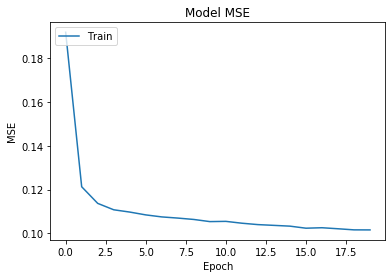

In [23]:
print("test RMSE", round(np.sqrt(mean_squared_error(test[target].values, pred_ans)), 4))
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))
import matplotlib.pyplot as plt
# print(history.history)
plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
plt.title('Model MSE') 
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [125]:
def plotPR(x_test,result):
    precisions=[]
    recalls=[]
    topNs=[]
    for topN in range(10,100+1,10):
        recall,precision=PrecisionRecall(x_test,result,topN)
        print("Recall: {}, Precision: {} ".format(round(recall,3),round(precision,3)))
        precisions.append(precision)
        recalls.append(recall)
        topNs.append(topN)
    plt.plot(topNs, recalls, label='Recalls')
    plt.title('Model TopN Recall')
    plt.ylabel('Recall')
    plt.xlabel('TopN')
    plt.legend(['Recalls', 'Precision'], loc='upper left')
    plt.show()
    
    
    plt.plot(topNs, precisions, label='Recalls')
    plt.title('Model TopN Precision')
    plt.ylabel('Precision')
    plt.xlabel('TopN')
    plt.legend(['Recalls', 'Precision'], loc='upper left')
    plt.show()
    

N is 10 
Evaluating the model......
Evaluation Finished!
Recall: 0.011, Precision: 0.012 
N is 20 
Evaluating the model......
Evaluation Finished!
Recall: 0.025, Precision: 0.013 
N is 30 
Evaluating the model......
Evaluation Finished!
Recall: 0.04, Precision: 0.014 
N is 40 
Evaluating the model......
Evaluation Finished!
Recall: 0.054, Precision: 0.014 
N is 50 
Evaluating the model......
Evaluation Finished!
Recall: 0.067, Precision: 0.014 
N is 60 
Evaluating the model......
Evaluation Finished!
Recall: 0.08, Precision: 0.014 
N is 70 
Evaluating the model......
Evaluation Finished!
Recall: 0.092, Precision: 0.013 
N is 80 
Evaluating the model......
Evaluation Finished!
Recall: 0.105, Precision: 0.013 
N is 90 
Evaluating the model......
Evaluation Finished!
Recall: 0.117, Precision: 0.013 
N is 100 
Evaluating the model......
Evaluation Finished!
Recall: 0.127, Precision: 0.013 


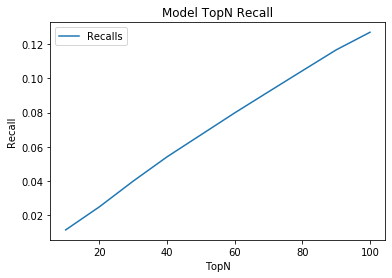

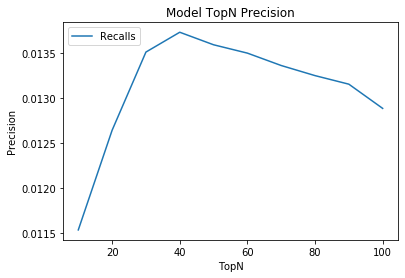

In [126]:
plotPR(test,result)

## Train FNN

In [81]:
# 4.Define Model,train,predict and evaluate
model = FNN(linear_feature_columns, dnn_feature_columns, task='regression',dnn_dropout=0.5)
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)


Train on 45314 samples, validate on 11329 samples
Epoch 1/10


/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yxy/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


45314/45314 - 4s - loss: 0.1586 - mse: 0.1586 - rmse: 0.2526 - val_loss: 0.1192 - val_mse: 0.1191 - val_rmse: 0.2140
Epoch 2/10
45314/45314 - 3s - loss: 0.1189 - mse: 0.1189 - rmse: 0.2188 - val_loss: 0.1186 - val_mse: 0.1185 - val_rmse: 0.2143
Epoch 3/10
45314/45314 - 3s - loss: 0.1135 - mse: 0.1134 - rmse: 0.2144 - val_loss: 0.1200 - val_mse: 0.1198 - val_rmse: 0.2177
Epoch 4/10
45314/45314 - 3s - loss: 0.1114 - mse: 0.1112 - rmse: 0.2126 - val_loss: 0.1193 - val_mse: 0.1192 - val_rmse: 0.2154
Epoch 5/10
45314/45314 - 3s - loss: 0.1093 - mse: 0.1091 - rmse: 0.2113 - val_loss: 0.1213 - val_mse: 0.1211 - val_rmse: 0.2210
Epoch 6/10
45314/45314 - 3s - loss: 0.1082 - mse: 0.1080 - rmse: 0.2112 - val_loss: 0.1202 - val_mse: 0.1200 - val_rmse: 0.2178
Epoch 7/10
45314/45314 - 3s - loss: 0.1060 - mse: 0.1057 - rmse: 0.2081 - val_loss: 0.1259 - val_mse: 0.1257 - val_rmse: 0.2314
Epoch 8/10
45314/45314 - 3s - loss: 0.1046 - mse: 0.1044 - rmse: 0.2083 - val_loss: 0.1215 - val_mse: 0.1213 - val_

test RMSE 0.3509
test MSE 0.1231


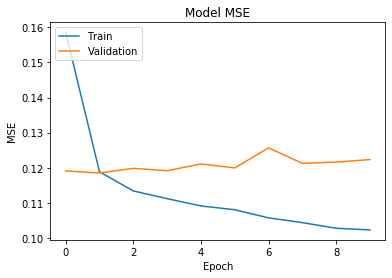

In [82]:
print("test RMSE", round(np.sqrt(mean_squared_error(test[target].values, pred_ans)), 4))
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))

import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [85]:
print(test)

       Unnamed: 0  adGroup  placement  settings  placementType    target
5276         5276      107        423         2              0  1.668000
1284         1284       30        450         2              0  1.658667
47296       47296      918        769         2              1  1.111667
43657       43657      850        412         2              0  0.212500
61132       61132     1219         21         2              1  1.143333
...           ...      ...        ...       ...            ...       ...
15100       15100      297        505         2              0  0.379167
1997         1997       39        682         0              1  0.311515
43192       43192      841        471         2              0  0.110000
28136       28136      569        375         2              0  0.568571
34133       34133      675        419         2              0  0.175333

[14161 rows x 6 columns]
